**Evaluating GOES images with coincident MODIS and ASTER**

What are the magnitude and distribution of differences between ABI-ASTER & MODIS-ASTER?
* Is there an East-to-West change in differences?
* Is there a North-to-South change in differences?
* Is there a relationship between differences and elevation, slope, or aspect?
* Is there a relationship between differences and fractional vegetation covered area?
* Is there a relationship between differences and fractional snow covered area? (from coincident MODIS)

In [248]:
import xarray as xr
from xhistogram.xarray import histogram
import richdem as rd
import rioxarray as rxr
import xrspatial as xrs
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
from scipy import stats
from scipy.linalg import lstsq
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pysolar
import datetime

from asp_binder_utils import get_dem

In [2]:
import warnings
warnings.filterwarnings('ignore')

Define functions

In [3]:
def summary_stats(a, b):
    '''Compute summary statistics for the difference between two sets.
    Input two flattened (1-D) arrays with NaN values removed'''
    
    # remove nan values
    a = a[np.isnan(a)==False]
    b = b[np.isnan(b)==False]
    
    # for difference stats
    diff = b - a
    
    # for linear regression stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(a, b)
    
    # populate dict with summary stats
    summary_stats_dict = {
        #'diff' : diff ,
        'n' : len(diff) ,
        'mean_diff' : np.nanmean( diff ),
        'median_diff' : np.nanmedian( diff ),
        'mean_squared_diff' : np.nanmean( diff**2 ),
        'rms_diff' : np.sqrt( np.nanmean( diff**2 ) ),
        'std_diff' : np.nanstd( diff ),
        'slope' : slope,
        'intercept' : intercept,
        'r_value' : r_value,
        'p_value' : p_value,
        'std_err' : std_err
        }
    
    return summary_stats_dict

In [4]:
def plot_regression_confidence_intervals(_x,_y,conf):

    # linear regression
    slope, intercept, r, p, se = stats.linregress(_x, _y)
    
    # predict y values of origional data using the fit
    p_y = slope*_x + intercept
    
    # calculate the y-error (residuals)
    y_err = _y - p_y
    
    # create series of new test x-values to predict for
    p_x = np.arange(np.min(_x),np.max(_x)+1,1)
    
    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(_x)                 # mean of x
    n = _x.size                          # number of samples in original fit
    t = stats.t.ppf(conf, n-2)            # find the appropriate t value (for n-2, and two tailed 95%)        
    sse = np.sum(y_err**2)              # sum of the squares of the residuals
    st_err = np.sqrt(sse/(n-2))         # standard error
    
    sigma = st_err**2 * (1 + 1/n + ( ( n*(p_x-mean_x)**2 ) / ( n*np.sum(_x**2) - np.sum(_x)**2 ) ) )
    confs = t * np.sqrt(sigma)
    
    # now predict y based on test x-values
    p_y = slope*p_x + intercept
    
    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - np.abs(confs)
    upper = p_y + np.abs(confs)
    
    # plot line of best fit
    c_x = np.array([_x.min(),_x.max()])
    c_y = slope*c_x + intercept
    plt.plot(c_x,c_y,'r--',label='Regression line')
    
    # plot confidence limits
    plt.plot(p_x,lower,':',c='grey',label='Lower confidence limit (95%)')
    plt.plot(p_x,upper,':',c='grey',label='Upper confidence limit (95%)')

In [5]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


Set up working area geometry

In [6]:
# Larger area around Tuolumne further south and east to include Mammoth
(utm_e_UL, utm_n_UL) = 282500, 4205000
(utm_e_UR, utm_n_UR) = 305000, 4205000
(utm_e_LR, utm_n_LR) = 327500, 4160000
(utm_e_LL, utm_n_LL) = 305000, 4160000

geometry = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [utm_e_UL, utm_n_UL],
            [utm_e_UR, utm_n_UR],
            [utm_e_LR, utm_n_LR],
            [utm_e_LL, utm_n_LL]
        ]]
    }
]

---
---
## Open dataset

In [7]:
_ds = xr.open_dataset('/storage/spestana/ASTER-MODIS-GOES-DEM-FVEG-FSCA_v5_orthorectified.nc')
_ds = _ds.rio.clip(geometry)
sel_these = [x for x in range(27) if (x != 25) & (x != 12)]
ds = _ds.isel(time=sel_these)

---

Day vs Night, overall

number of pixels:  604019 1245885
means:  2.2 0.7
mean diff: 1.5
medians:  2.5 0.8


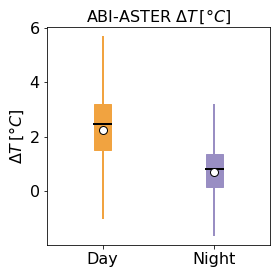

In [8]:
conf = 0.975

ds_day = ds.where(ds.time.dt.hour==18, drop=True)
ds_night = ds.where(ds.time.dt.hour==6, drop=True)

########################################################

x_night = ds_night.ast_goes_mean_diff_tb.values.ravel()
x_night = x_night[~np.isnan(x_night)]
x_day = ds_day.ast_goes_mean_diff_tb.values.ravel()
x_day = x_day[~np.isnan(x_day)]

plt.figure(figsize=(4,4))

bplot = plt.boxplot([x_day, 
                     x_night],vert=True,
                     showfliers=False, showmeans=True, patch_artist=True,
                     labels=['Day', 'Night']);

color1='#f1a340'
color2='#998ec3'
# fill with colors
colors = [color1, color2]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_edgecolor(color)
    patch.set_facecolor(color)
colors = ['k', 'k']
for patch, color in zip(bplot['medians'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['means'], colors):
    patch.set_markeredgecolor(color)
    patch.set_markerfacecolor('w')
    patch.set_marker('o')
    patch.set_markersize(8)
for patch, color in zip(bplot['fliers'], colors):
    patch.set_markeredgecolor(color)
    patch.set_markersize(1)
    patch.set_marker('.')
colors = [color1, color1, color2, color2]
for patch, color in zip(bplot['whiskers'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['caps'], colors):
    patch.set_color(color)
    patch.set_linewidth(0)
    
    
    
plt.title('ABI-ASTER $\Delta T\,[\degree C]$')
plt.ylabel('$\Delta T\,[\degree C]$')

#plt.ylim(-6,6);

print('number of pixels: ',len(x_day),len(x_night))
print('means: ',np.round(np.mean(x_day),1),np.round(np.mean(x_night),1))
print(f'mean diff: {np.round(np.mean(x_day)-np.mean(x_night),1)}')
print('medians: ',np.round(np.median(x_day),1),np.round(np.median(x_night),1))


Daytime ast_goes_summary_stats {'n': 604019, 'mean_diff': 2.3743133602586344, 'median_diff': 2.8734967956706896, 'mean_squared_diff': 24.268590416778125, 'rms_diff': 4.9263161101149535, 'std_diff': 4.31639044620334, 'slope': 0.6226856889981677, 'intercept': 106.77060911298781, 'r_value': 0.8024881882276732, 'p_value': 0.0, 'std_err': 0.0005957148206457926}
Nighttime ast_goes_summary_stats {'n': 1245885, 'mean_diff': 0.7438236753908487, 'median_diff': 0.753379770403285, 'mean_squared_diff': 7.0803560026788075, 'rms_diff': 2.660893835288963, 'std_diff': 2.5548155202689, 'slope': 0.8355105924139725, 'intercept': 44.754755600262996, 'r_value': 0.9218820622337053, 'p_value': 0.0, 'std_err': 0.0003146130384938884}


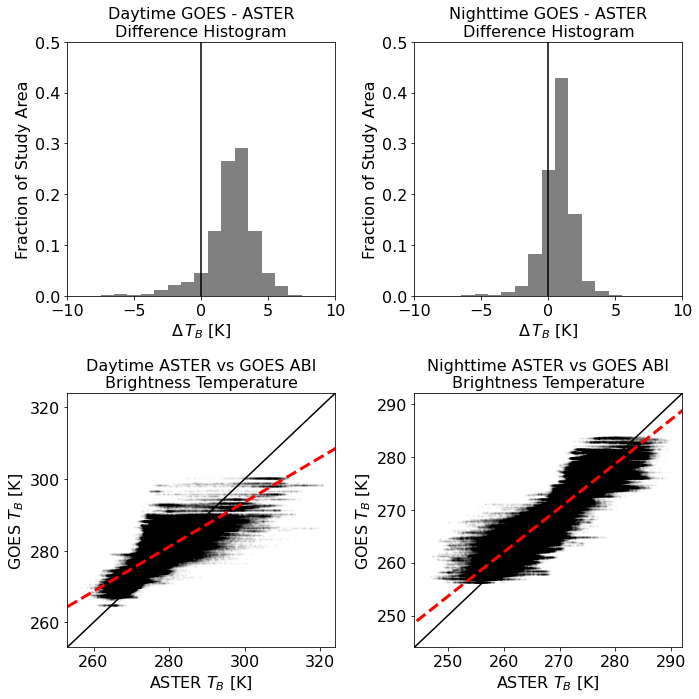

In [9]:
z_night = ds_night.ast_goes_mean_diff_tb.values.ravel()
z_night = z_night[~np.isnan(z_night)]
z_day = ds_day.ast_goes_mean_diff_tb.values.ravel()
z_day = z_day[~np.isnan(z_day)]


x_night = ds_night.ast_goes_aster_rad2tbK.values.ravel()
x_night = x_night[~np.isnan(x_night)]
x_day = ds_day.ast_goes_aster_rad2tbK.values.ravel()
x_day = x_day[~np.isnan(x_day)]

y_night = ds_night.ast_goes_goes_tb.values.ravel()
y_night = y_night[~np.isnan(y_night)]
y_day = ds_day.ast_goes_goes_tb.values.ravel()
y_day = y_day[~np.isnan(y_day)]

# make figure
fig = plt.figure(figsize=(10,10), tight_layout=True)
nrows = 2
ncols = 2

# make hist plot axes
ax_ast_goes_orig_hist = plt.subplot2grid((nrows, ncols), (0, 0), 1, 1)
ax_ast_goes_ortho_hist = plt.subplot2grid((nrows, ncols), (0, 1), 1, 1)

# make 1-to-1 plots axes
ax_ast_goes_orig_1to1 = plt.subplot2grid((nrows, ncols), (1, 0), 1, 1)
ax_ast_goes_ortho_1to1 = plt.subplot2grid((nrows, ncols), (1, 1), 1, 1)

mybins = np.arange(-10.5,11.5,1)

# Daytime GOES-ASTER
ax_ast_goes_orig_hist.hist(z_day, bins=mybins, color='grey', density=True, label='$\sigma$ = {}'.format(np.round(x_day.std(),1)))
#ax_ast_goes_orig_hist.axvline(_ds_original.ast_goes_mean_diff_tb.mean(), color='r', linestyle='--', lw=lw, label='$\mu$ = {}'.format(np.round(_ds_original.ast_goes_mean_diff_tb.mean().values,1))) # mean line
ax_ast_goes_orig_hist.set_title('Daytime GOES - ASTER\nDifference Histogram')

# Nighttime GOES-ASTER
ax_ast_goes_ortho_hist.hist(z_night, bins=mybins, color='grey', density=True, label='$\sigma$ = {}'.format(np.round(x_night.std(),1)))
#ax_ast_goes_ortho_hist.axvline(_ds_ortho.ast_goes_mean_diff_tb.mean(), color='r', linestyle='--', lw=lw, label='$\mu$ = {}'.format(np.round(_ds_ortho.ast_goes_mean_diff_tb.mean().values,1))) # mean line
ax_ast_goes_ortho_hist.set_title('Nighttime GOES - ASTER\nDifference Histogram')



# Daytime ASTER and GOES
ax_ast_goes_orig_1to1.plot(x_day, y_day, # aggregated ASTER vs GOES
                      linestyle='none', marker='.', color='k', alpha=0.02, markersize=3)
ax_ast_goes_orig_1to1.set_title('Daytime ASTER vs GOES ABI\nBrightness Temperature')
ax_ast_goes_orig_1to1.set_xlabel('ASTER $T_B$ [K]')
ax_ast_goes_orig_1to1.set_ylabel('GOES $T_B$ [K]')

# Nighttime ASTER and GOES
ax_ast_goes_ortho_1to1.plot(x_night, y_night, # aggregated ASTER vs GOES
                      linestyle='none', marker='.', color='k', alpha=0.02, markersize=3)
ax_ast_goes_ortho_1to1.set_title('Nighttime ASTER vs GOES ABI\nBrightness Temperature')
ax_ast_goes_ortho_1to1.set_xlabel('ASTER $T_B$ [K]')
ax_ast_goes_ortho_1to1.set_ylabel('GOES $T_B$ [K]')



### Format the axes limits on the histograms ###
for ax in [ax_ast_goes_orig_hist, ax_ast_goes_ortho_hist]:#[ax_ast_mod_day_hist,ax_ast_mod_night_hist, ax_ast_goes_orig_hist, ax_ast_goes_ortho_hist]:
    ax.set_xlim(-10,10)
    ax.set_ylim(0,0.5)
    ax.axvline(0, color='k', linestyle='-') # zero line
    #ax.legend(loc='upper left',facecolor='none',edgecolor='none')
    ax.set_xlabel('$\Delta\,T_B$ [K]')
    ax.set_ylabel('Fraction of Study Area')
    
### 1-to-1 plots and axes formatting ###
for ax_1_to_1 in [ax_ast_goes_orig_1to1, ax_ast_goes_ortho_1to1]:#[ax_ast_mod_day_1to1, ax_ast_mod_night_1to1, ax_ast_goes_orig_1to1, ax_ast_goes_ortho_1to1]:
    # get max and min values for axes
    (ax_min, ax_max) = (int(np.floor( np.min( [ax_1_to_1.get_xlim()[0], ax_1_to_1.get_ylim()[0]] ) )), 
                        int(np.ceil( np.max( [ax_1_to_1.get_xlim()[1], ax_1_to_1.get_ylim()[1]] ) )) )
    # add 1-to-1 line
    ax_1_to_1.plot([ax_min,ax_max],[ax_min,ax_max],'k-')
    # set axes limits
    ax_1_to_1.set_xlim((ax_min,ax_max))
    ax_1_to_1.set_ylim((ax_min,ax_max))

lw=3
x = np.array([200,400])
# Daytime GOES - ASTER
ast_goes_orig_summary_stats = summary_stats(x_day, y_day)
print('Daytime ast_goes_summary_stats',ast_goes_orig_summary_stats)
ax_ast_goes_orig_1to1.plot(x, x*ast_goes_orig_summary_stats['slope'] + ast_goes_orig_summary_stats['intercept'],linestyle='--', lw=lw, color='r')

# Nighttime GOES - ASTER
ast_goes_ortho_summary_stats = summary_stats(x_night,y_night)
print('Nighttime ast_goes_summary_stats',ast_goes_ortho_summary_stats)
ax_ast_goes_ortho_1to1.plot(x, x*ast_goes_ortho_summary_stats['slope'] + ast_goes_ortho_summary_stats['intercept'],linestyle='--', lw=lw, color='r')


plt.savefig('images/day-vs-night-ortho-Figure5-v2.png',dpi=200)

### Make two zonal categories, based on fveg

1) fveg > 0.5 or median fveg

2) fveg < 0.5 or median fveg

In [10]:
#plt.figure(figsize=(5,5))
#ds.tcc.plot.hist(bins=20);

In [11]:
#k = ds.fveg.quantile(0.5, dim=('x','y'))
#
#
##n=7
##ds.isel(time=n).ast_goes_mean_diff_rad.plot(cmap='RdBu_r', vmin=-10, vmax=10, figsize=(15,12))
##ds.fveg.where(ds.fveg>k).isel(time=n).plot(cmap='Greens',add_colorbar=False)
#
#
#
#
## Group A:
#group_a = ds.where(ds.fveg > k).where(ds.time.dt.hour > 12).ast_goes_mean_diff_rad.values.ravel()
#group_a = group_a[~np.isnan(group_a)]
## Group B:
#group_b = ds.where(ds.fveg <= k).where(ds.time.dt.hour > 12).ast_goes_mean_diff_rad.values.ravel()
#group_b = group_b[~np.isnan(group_b)]
#
#
#print(len(group_a),len(group_b))
#plt.figure()
#plt.boxplot([group_a, 
#             group_b], showfliers=False);
#
#
#
## Group A:
#group_a = ds.where(ds.fveg > k).where(ds.time.dt.hour < 12).ast_goes_mean_diff_rad.values.ravel()
#group_a = group_a[~np.isnan(group_a)]
## Group B:
#group_b = ds.where(ds.fveg <= k).where(ds.time.dt.hour < 12).ast_goes_mean_diff_rad.values.ravel()
#group_b = group_b[~np.isnan(group_b)]
#
#
#print(len(group_a),len(group_b))
#plt.figure()
#plt.boxplot([group_a, 
#             group_b], showfliers=False);

In [12]:
#gt_k = []
#lt_k = []
#medians = []
#times = []
#
#for i in range(0,len(ds.time)):
#    if ds.time.isel(time=i).dt.hour > 12:
#        # find the 50% quantile (median) (or some other quantile) and use that as the threshold
#        xx = ds.fveg.isel(time=i).values.ravel()
#        xx = xx[~np.isnan(xx)]
#        q50 = np.quantile(xx, 0.50) # median
#        k = q50
#        times.append(ds.time.isel(time=i).values)
#        medians.append(k)
#        gt_k.append(ds.ast_goes_aster_rad2tbK.where(ds.fveg >= k).isel(time=i).mean().values)
#        lt_k.append(ds.ast_goes_aster_rad2tbK.where(ds.fveg < k).isel(time=i).mean().values)
#
#plt.figure(figsize=(10,5))
#plt.plot(times, gt_k, 'o-')
#plt.plot(times, lt_k,'o-')
##plt.plot(times,np.array(gt_k)-np.array(lt_k),'o-')

In [13]:
#gt_k = []
#lt_k = []
#medians = []
#times = []
#
#for i in range(0,len(ds.time)):
#    if ds.time.isel(time=i).dt.hour > 12:
#        # find the 50% quantile (median) (or some other quantile) and use that as the threshold
#        xx = ds.fveg.isel(time=i).values.ravel()
#        xx = xx[~np.isnan(xx)]
#        q50 = np.quantile(xx, 0.50) # median
#        k = q50
#        times.append(ds.time.isel(time=i).values)
#        medians.append(k)
#        gt_k.append(ds.ast_goes_mean_diff_tb.where(ds.fveg >= k).isel(time=i).mean().values)
#        lt_k.append(ds.ast_goes_mean_diff_tb.where(ds.fveg < k).isel(time=i).mean().values)
#
#plt.figure(figsize=(10,5))
#plt.plot(times, gt_k, 'o-')
#plt.plot(times, lt_k, 'o-')
##plt.ylim(-3.5,3.5)
##plt.plot(times,np.array(gt_k)-np.array(lt_k),'o-')

### Make three zonal categories, 

1) terrain facing GOES-16 ABI, (hillshade values > 0.5)

2) terrain facing away from GOES-16 ABI, (0.0 < hillshade values < 0.5)

3) occluded terrain not visible to GOES-16 ABI. (hillshade Values < 0.0)

**For daytime only**

In [14]:
#fig, [ax1, ax2, ax3] = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
#ds.dem.plot.hist(bins=100, ax=ax1);
#ds.dem_slope.plot.hist(bins=100, ax=ax2);
#ds.dem_aspect.plot.hist(bins=100, ax=ax3);
#


In [15]:
#plt.figure(figsize=(10,5))
#ds.sat_hillshade.isel(time=0).plot.hist(bins=200,alpha=0.5, label='Satellite hillshade from -89.5');
#ds.sat_hillshade.isel(time=20).plot.hist(bins=200,alpha=0.5, label='Satellite hillshade from -75.2');
#plt.axvline(0,c='k')
#plt.axvline(0.5,c='k')
#plt.legend()

In [16]:
## Group A: terrain facing GOES-16 ABI, (hillshade values => 0.5)
#group_a = ds.where(ds.time.dt.hour > 12).where(ds.sat_hillshade >= 0.75).ast_goes_aster_rad2tbK.values.ravel()
#group_a = group_a[~np.isnan(group_a)]
## Group B: terrain facing away from GOES-16 ABI, (0.0 <= hillshade values < 0.5)
#group_b = ds.where(ds.time.dt.hour > 12).where(ds.sat_hillshade < 0.75).where(ds.sat_hillshade >= 0.0).ast_goes_aster_rad2tbK.values.ravel()
#group_b = group_b[~np.isnan(group_b)]
## Group C: occluded terrain not visible to GOES-16 ABI. (hillshade Values < 0.0)
#group_c = ds.where(ds.time.dt.hour > 12).where(ds.sat_hillshade < 0.0).ast_goes_aster_rad2tbK.values.ravel()
#group_c = group_c[~np.isnan(group_c)]
#
#print(len(group_a),len(group_b),len(group_c))
#
#plt.boxplot([group_a, 
#             group_b, 
#             group_c], showfliers=False);

**For daytime, look at **

### Make two zonal categories, 

1) terrain facing the sun (hillshade values > median hillshade)

2) terrain facing away from the sun, (hillshade values < median hillshade)



In [17]:
#plt.figure(figsize=(10,5))
#for i in range(0,len(ds.time)):
#    if ds.time.isel(time=i).dt.hour > 12:
#        ds.solar_hillshade.isel(time=i).plot.hist(bins=200,color='red',alpha=0.2);
#plt.axvline(0,c='k')
#plt.axvline(0.75,c='k')        
#plt.title('Solar Hillshade over time');

In [18]:
#k

In [19]:
## ASTER Temperatures by group
#k = ds.solar_hillshade.quantile(0.75, dim=('x','y'))#ds.solar_hillshade.median(axis=(1,2))
#
## Group A: terrain facing the Sun, (hillshade values => 0.5)
#group_a = ds.where(ds.time.dt.hour > 12).where(ds.solar_hillshade >= k).ast_goes_aster_rad2tbK.values.ravel()
#group_a = group_a[~np.isnan(group_a)]
## Group B: terrain facing away from  the Sun, (0.0 <= hillshade values < 0.5)
#group_b = ds.where(ds.time.dt.hour > 12).where(ds.solar_hillshade < k).ast_goes_aster_rad2tbK.values.ravel()
#group_b = group_b[~np.isnan(group_b)]
### Group C: occluded terrain not visible to the Sun (in shade). (hillshade Values < 0.0)
##group_c = ds.where(ds.time.dt.hour > 12).where(ds.solar_hillshade_goes_zonal_mean < 0.0).ast_goes_aster_rad2tbK.values.ravel()
##group_c = group_c[~np.isnan(group_c)]
## Group D: all nighttime values
#group_d = ds.where(ds.time.dt.hour < 12).ast_goes_aster_rad2tbK.values.ravel()
#group_d = group_d[~np.isnan(group_d)]
#
#
#print(len(group_a),len(group_b),len(group_c),len(group_d))
#
##plt.boxplot([group_a, 
##             group_b, 
##             #group_c,
##             group_d], showfliers=True);
#
#plt.hist(group_a,bins=100,alpha=0.5);
#plt.hist(group_b,bins=100,alpha=0.5);
##plt.hist(group_d,bins=100,alpha=0.5);

In [20]:
## ABI - ASTER deltaT by group
#k = ds.solar_hillshade.quantile(0.75, dim=('x','y'))#ds.solar_hillshade.median(axis=(1,2))
#
## Group A: terrain facing the Sun, (hillshade values => 0.5)
#group_a = ds.where(ds.time.dt.hour > 12).where(ds.solar_hillshade >= k).ast_goes_mean_diff_tb.values.ravel()
#group_a = group_a[~np.isnan(group_a)]
## Group B: terrain facing away from  the Sun, (hillshade values < 0.5)
#group_b = ds.where(ds.time.dt.hour > 12).where(ds.solar_hillshade < k).ast_goes_mean_diff_tb.values.ravel()
#group_b = group_b[~np.isnan(group_b)]
### Group C: occluded terrain not visible to the Sun (in shade). (hillshade Values < 0.0)
##group_c = ds.where(ds.time.dt.hour > 12).where(ds.solar_hillshade_goes_zonal_mean < 0.0).ast_goes_mean_diff_tb.values.ravel()
##group_c = group_c[~np.isnan(group_c)]
## Group D: all nighttime values
#group_d = ds.where(ds.time.dt.hour < 12).ast_goes_mean_diff_tb.values.ravel()
#group_d = group_d[~np.isnan(group_d)]
#
#
#print(len(group_a),len(group_b),len(group_c),len(group_d))
#
##plt.boxplot([group_a, 
##             group_b, 
##             #group_c,
##             group_d], showfliers=True);
##
#plt.hist(group_a,bins=100,alpha=0.5);
#plt.hist(group_b,bins=100,alpha=0.5);
##plt.hist(group_d,bins=100,alpha=0.5);

In [21]:
#gt_k = []
#lt_k = []
#medians = []
#times = []
#
#for i in range(0,len(ds.time)):
#    if ds.time.isel(time=i).dt.hour > 12:
#        # find the 50% quantile (median) (or some other quantile) and use that as the threshold
#        xx = ds.solar_hillshade.isel(time=i).values.ravel()
#        xx = xx[~np.isnan(xx)]
#        q50 = np.quantile(xx, 0.50) # median
#        k = q50
#        times.append(ds.time.isel(time=i).values)
#        medians.append(k)
#        gt_k.append(ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade >= k).isel(time=i).mean().values)
#        lt_k.append(ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade < k).isel(time=i).mean().values)
#
#plt.figure(figsize=(10,5))
#plt.plot(times, gt_k, 'o-')
#plt.plot(times, lt_k,'o-')
##plt.plot(times,np.array(gt_k)-np.array(lt_k),'o-')
#
#############################################################
##
##gt_k = []
##lt_k = []
##medians = []
##
##for i in range(0,len(ds.time)):
##    if ds.time.isel(time=i).dt.hour > 12:
##        # find the 50% quantile (median) (or some other quantile) and use that as the threshold
##        xx = ds.solar_hillshade.isel(time=i).values.ravel()
##        xx = xx[~np.isnan(xx)]
##        q50 = np.quantile(xx, 0.50) # median
##        k = q50
##        medians.append(k)
##        gt_k.append(ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade_goes_zonal_mean >= k).isel(time=n).mean().values)
##        lt_k.append(ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade_goes_zonal_mean < k).isel(time=n).mean().values)
##
##plt.figure(figsize=(10,5))
##plt.plot(gt_k)
##plt.plot(lt_k)

In [22]:
#gt_k = []
#lt_k = []
#medians = []
#times = []
#
#for i in range(0,len(ds.time)):
#    if ds.time.isel(time=i).dt.hour > 12:
#        # find the 50% quantile (median) (or some other quantile) and use that as the threshold
#        xx = ds.solar_hillshade.isel(time=i).values.ravel()
#        xx = xx[~np.isnan(xx)]
#        q50 = np.quantile(xx, 0.50) # median
#        k = q50
#        times.append(ds.time.isel(time=i).values)
#        medians.append(k)
#        gt_k.append(ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade >= k).isel(time=i).mean().values)
#        lt_k.append(ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade < k).isel(time=i).mean().values)
#
#plt.figure(figsize=(10,5))
#plt.plot(times, gt_k, 'o-')
#plt.plot(times, lt_k, 'o-')
##plt.ylim(-3.5,3.5)
##plt.plot(times,np.array(gt_k)-np.array(lt_k),'o-')
#
#
#############################################################
##
##
##gt_k = []
##lt_k = []
##medians = []
##
##for i in range(0,len(ds.time)):
##    if ds.time.isel(time=i).dt.hour > 12:
##        # find the 50% quantile (median) (or some other quantile) and use that as the threshold
##        xx = ds.solar_hillshade.isel(time=i).values.ravel()
##        xx = xx[~np.isnan(xx)]
##        q50 = np.quantile(xx, 0.50) # median
##        k = q50
##        medians.append(k)
##        gt_k.append(ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade_goes_zonal_mean >= k).isel(time=n).mean().values)
##        lt_k.append(ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade_goes_zonal_mean < k).isel(time=n).mean().values)
##
##plt.figure(figsize=(10,5))
##plt.plot(gt_k)
##plt.plot(lt_k)

In [23]:
#n=26
## find the 50% quantile (median) (or some other quantile) and use that as the threshold
#xx = ds.solar_hillshade.isel(time=n).values.ravel()
#xx = xx[~np.isnan(xx)]
#q50 = np.quantile(xx, 0.50) # median
#k = q50
#print(k)
#
#plt.figure(figsize=(5,5))
#ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade >= k).isel(time=n).plot(cmap='Greys',vmin=250,vmax=300,add_colorbar=False)
#print(ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade >= k).isel(time=n).mean().values)
#plt.figure(figsize=(5,5))
#ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade < k).isel(time=n).plot(cmap='Greys',vmin=250,vmax=300,add_colorbar=False)
#print(ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade < k).isel(time=n).mean().values)
#
#
#plt.figure(figsize=(5,5))
#ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade >= k).isel(time=n).plot(cmap='RdBu_r',vmin=-5,vmax=5,add_colorbar=False)
#print(ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade >= k).isel(time=n).mean().values)
#plt.figure(figsize=(5,5))
#ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade < k).isel(time=n).plot(cmap='RdBu_r',vmin=-5,vmax=5,add_colorbar=False)
#print(ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade < k).isel(time=n).mean().values)

In [24]:
#n=26
## find the 50% quantile (median) (or some other quantile) and use that as the threshold
#xx = ds.solar_hillshade_goes_zonal_mean.isel(time=n).values.ravel()
#xx = xx[~np.isnan(xx)]
#q50 = np.quantile(xx, 0.50) # median
#k = q50
#print(k)
#
#plt.figure(figsize=(5,5))
#ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade_goes_zonal_mean >= k).isel(time=n).plot(cmap='Greys',vmin=250,vmax=300,add_colorbar=False)
#print(ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade_goes_zonal_mean >= k).isel(time=n).mean().values)
#plt.figure(figsize=(5,5))
#ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade_goes_zonal_mean < k).isel(time=n).plot(cmap='Greys',vmin=250,vmax=300,add_colorbar=False)
#print(ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade_goes_zonal_mean < k).isel(time=n).mean().values)
#
#
#plt.figure(figsize=(5,5))
#ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade_goes_zonal_mean >= k).isel(time=n).plot(cmap='RdBu_r',vmin=-5,vmax=5,add_colorbar=False)
#print(ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade_goes_zonal_mean >= k).isel(time=n).mean().values)
#plt.figure(figsize=(5,5))
#ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade_goes_zonal_mean < k).isel(time=n).plot(cmap='RdBu_r',vmin=-5,vmax=5,add_colorbar=False)
#print(ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade_goes_zonal_mean < k).isel(time=n).mean().values)

In [25]:
## Group A: terrain facing the Sun, (hillshade values => 0.5)
#group_a = ds.where(ds.time.dt.hour > 12).where(ds.solar_hillshade >= 0.5).ast_goes_aster_rad2tbK.values.ravel()
#group_a = group_a[~np.isnan(group_a)]
## Group B: terrain facing away from  the Sun, (0.0 <= hillshade values < 0.5)
#group_b = ds.where(ds.time.dt.hour > 12).where(ds.solar_hillshade < 0.5).where(ds.solar_hillshade >= 0.0).ast_goes_aster_rad2tbK.values.ravel()
#group_b = group_b[~np.isnan(group_b)]
## Group C: occluded terrain not visible to the Sun (in shade). (hillshade Values < 0.0)
#group_c = ds.where(ds.time.dt.hour > 12).where(ds.solar_hillshade < 0.0).ast_goes_aster_rad2tbK.values.ravel()
#group_c = group_c[~np.isnan(group_c)]
## Group D: all nighttime values
#group_d = ds.where(ds.time.dt.hour < 12).ast_goes_aster_rad2tbK.values.ravel()
#group_d = group_d[~np.isnan(group_d)]
#
#
#print(len(group_a),len(group_b),len(group_c),len(group_d))
#
#plt.boxplot([group_a, 
#             group_b, 
#             group_c,
#             group_d], showfliers=False);

what if I weighted ASTER by GOES satellite view hillslope?

In [26]:
#t = 10
#ds.where(ds.sat_hillshade>=0, 0).isel(time=t).sat_hillshade.plot(cmap='Greys_r',figsize=(5,5))
#ds.isel(time=t).ast_goes_aster_rad.plot(cmap='magma',figsize=(5,5))
#
#weighted = ds.ast_goes_aster_rad * ds.sat_hillshade.where(ds.sat_hillshade>=0, 0)#.where(ds.sat_hillshade<=0,1)
#weighted.isel(time=t).plot(cmap='magma',figsize=(5,5))
#
#(weighted - ds.ast_goes_aster_rad).isel(time=t).plot(cmap='RdBu_r',vmin=-5, vmax=5,figsize=(5,5))

---
---
---

---

set up quick plot function

In [27]:
def quick_plot(x,y,x_label,y_label, conf, add_linear_regression=True):
    plt.figure(figsize=(4,4))
    plt.scatter(x,y,marker='.',c='k',alpha=0.02,s=1)
    _x = x[~np.isnan(x)]
    _y = y[~np.isnan(x)]
    slope, intercept, r, p, se = stats.linregress(_x, _y)
    print(slope, intercept, r, p, se)
    if add_linear_regression == True:
        plt.plot(np.linspace(_x.min(),_x.max()),
                 slope*np.linspace(_x.min(),_x.max())+intercept,
                 '--r',zorder=99)
        plot_regression_confidence_intervals(_x,_y,conf)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(f'{x_label}\nversus {y_label}')
    return None

---
---

### Elevation

deltaT versus Elevation for all 25 observations

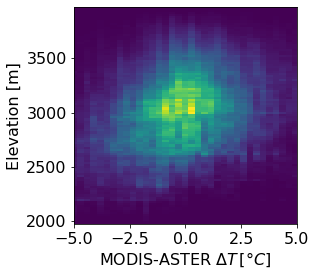

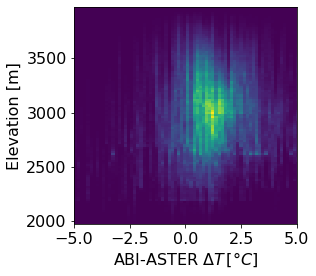

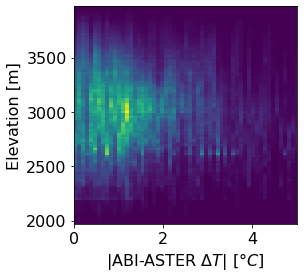

In [28]:
conf = 0.975


y = np.array([ds.dem.values] * len(ds.time)).ravel()

# MODIS-ASTER deltaT
x = ds.ast_mod_mean_diff_tb.values.ravel()
#quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','Elevation [m]', conf)
plt.figure(figsize=(4,4))
plt.hist2d(x[~np.isnan(x) & ~np.isnan(y)],y[~np.isnan(x) & ~np.isnan(y)],bins=[200,100]);
plt.xlabel('MODIS-ASTER $\Delta T\,[\degree C]$')
plt.ylabel('Elevation [m]');
plt.xlim(-5,5);


# ABI-ASTER deltaT
x = ds.ast_goes_mean_diff_tb.values.ravel()
#quick_plot(x,y,'ABI-ASTER $\Delta T\,[\degree C]$','Elevation [m]', conf)
plt.figure(figsize=(4,4))
plt.hist2d(x[~np.isnan(x) & ~np.isnan(y)],y[~np.isnan(x) & ~np.isnan(y)],bins=[200,100]);
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.ylabel('Elevation [m]');
plt.xlim(-5,5);


## Absolute value of ABI-ASTER deltaT
x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
#quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','Elevation [m]', conf)
plt.figure(figsize=(4,4))
plt.hist2d(x[~np.isnan(x) & ~np.isnan(y)],y[~np.isnan(x) & ~np.isnan(y)],bins=[200,100]);
plt.xlabel('|ABI-ASTER $\Delta T$| $[\degree C]$')
plt.ylabel('Elevation [m]');
plt.xlim(0,5);



boxplots

elevation bin: 2000, n: 19566, mean: 0.0
elevation bin: 2500, n: 451770, mean: 0.9
elevation bin: 3000, n: 1015949, mean: 1.3
elevation bin: 3500, n: 449581, mean: 1.2
elevation bin: 4000, n: 18300, mean: 1.0


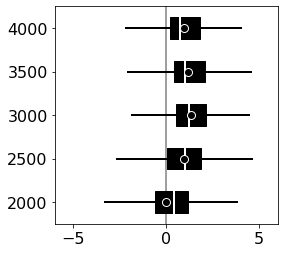

In [236]:
### Both day and night

_y = np.array([ds.dem.values] * len(ds.time)).ravel()

# GOES-ASTER deltaT
_x = ds.ast_goes_mean_diff_tb.values.ravel()
x = _x[~np.isnan(_x) & ~np.isnan(_y)]
y = _y[~np.isnan(_x) & ~np.isnan(_y)]

round_to_the_nearest = 500 # meters in elevation
y_rounded = np.round(y/round_to_the_nearest,0)*round_to_the_nearest
x_binned = [x[y_rounded==elevation_bin] for elevation_bin in np.unique(y_rounded)]
labels = [label[:-2] for label in list(map(str, np.unique(y_rounded).tolist()))]

_ = [print(f'elevation bin: {labels[i]}, n: {len(this_x_binned)}, mean: {np.round(np.mean(this_x_binned),1)}') for i, this_x_binned in enumerate(x_binned)]

#quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','Elevation [m]', conf)

plt.figure(figsize=(4,4))
bplot = plt.boxplot(x_binned,vert=False,
                     showfliers=False, showmeans=True, patch_artist=True,
                     labels=labels);


plt.axvline(0,linestyle='-',color='grey', zorder=-99)

# fill with colors
color1 = '#000000'
colors = [color1]*len(labels)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_edgecolor(color)
    patch.set_facecolor(color)
colors = ['w']*len(labels)
for patch, color in zip(bplot['medians'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['means'], colors):
    patch.set_markeredgecolor(color)
    patch.set_markerfacecolor('k')
    patch.set_marker('o')
    patch.set_markersize(8)
for patch, color in zip(bplot['fliers'], colors):
    patch.set_markeredgecolor(color)
    patch.set_markersize(1)
    patch.set_marker('.')
colors = [color1, color1]*len(labels)
for patch, color in zip(bplot['whiskers'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['caps'], colors):
    patch.set_color(color)
    patch.set_linewidth(0)

plt.xlim(-6,6);



In [190]:
ds_day = ds.where(ds.time.dt.hour>6, drop=True)
ds_night = ds.where(ds.time.dt.hour<=6, drop=True)

elevation bin: 2000, n: 3363, mean: 2.2
elevation bin: 2500, n: 80207, mean: 2.2
elevation bin: 3000, n: 153163, mean: 2.2
elevation bin: 3500, n: 64929, mean: 2.1
elevation bin: 4000, n: 3143, mean: 2.3


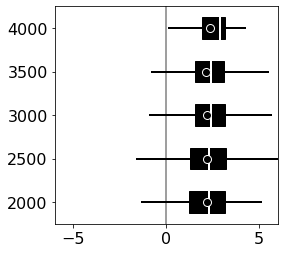

In [237]:
conf = 0.975


#### DAY

_y = ds_day.dem.values.ravel()

# GOES-ASTER deltaT
_x = ds_day.ast_goes_mean_diff_tb.values.ravel()
x = _x[~np.isnan(_x) & ~np.isnan(_y)]
y = _y[~np.isnan(_x) & ~np.isnan(_y)]

round_to_the_nearest = 500 # meters in elevation
y_rounded = np.round(y/round_to_the_nearest,0)*round_to_the_nearest
x_binned = [x[y_rounded==elevation_bin] for elevation_bin in np.unique(y_rounded)]
labels = [label[:-2] for label in list(map(str, np.unique(y_rounded).tolist()))]

_ = [print(f'elevation bin: {labels[i]}, n: {len(this_x_binned)}, mean: {np.round(np.mean(this_x_binned),1)}') for i, this_x_binned in enumerate(x_binned)]

#quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','Elevation [m]', conf)

plt.figure(figsize=(4,4))
bplot = plt.boxplot(x_binned,vert=False,
                     showfliers=False, showmeans=True, patch_artist=True,
                     labels=labels);


plt.axvline(0,linestyle='-',color='grey', zorder=-99)

# fill with colors
color1 = '#000000'
colors = [color1]*len(labels)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_edgecolor(color)
    patch.set_facecolor(color)
colors = ['w']*len(labels)
for patch, color in zip(bplot['medians'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['means'], colors):
    patch.set_markeredgecolor(color)
    patch.set_markerfacecolor('k')
    patch.set_marker('o')
    patch.set_markersize(8)
for patch, color in zip(bplot['fliers'], colors):
    patch.set_markeredgecolor(color)
    patch.set_markersize(1)
    patch.set_marker('.')
colors = [color1, color1]*len(labels)
for patch, color in zip(bplot['whiskers'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['caps'], colors):
    patch.set_color(color)
    patch.set_linewidth(0)


plt.xlim(-6,6);


elevation bin: 2000, n: 8512, mean: 0.2
elevation bin: 2500, n: 165918, mean: 0.7
elevation bin: 3000, n: 366674, mean: 0.8
elevation bin: 3500, n: 130778, mean: 0.7
elevation bin: 4000, n: 5048, mean: 0.6


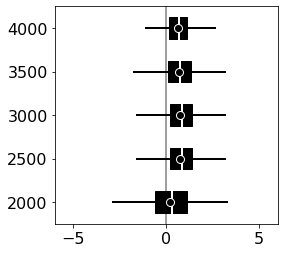

In [238]:
##### NIGHT

_y = ds_night.dem.values.ravel()

# GOES-ASTER deltaT
_x = ds_night.ast_goes_mean_diff_tb.values.ravel()
x = _x[~np.isnan(_x) & ~np.isnan(_y)]
y = _y[~np.isnan(_x) & ~np.isnan(_y)]

round_to_the_nearest = 500 # meters in elevation
y_rounded = np.round(y/round_to_the_nearest,0)*round_to_the_nearest
x_binned = [x[y_rounded==elevation_bin] for elevation_bin in np.unique(y_rounded)]
labels = [label[:-2] for label in list(map(str, np.unique(y_rounded).tolist()))]

_ = [print(f'elevation bin: {labels[i]}, n: {len(this_x_binned)}, mean: {np.round(np.mean(this_x_binned),1)}') for i, this_x_binned in enumerate(x_binned)]

#quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','Elevation [m]', conf)

plt.figure(figsize=(4,4))
bplot = plt.boxplot(x_binned,vert=False,
                     showfliers=False, showmeans=True, patch_artist=True,
                     labels=labels);


plt.axvline(0,linestyle='-',color='grey', zorder=-99)

# fill with colors
color1 = '#000000'
colors = [color1]*len(labels)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_edgecolor(color)
    patch.set_facecolor(color)
colors = ['w']*len(labels)
for patch, color in zip(bplot['medians'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['means'], colors):
    patch.set_markeredgecolor(color)
    patch.set_markerfacecolor('k')
    patch.set_marker('o')
    patch.set_markersize(8)
for patch, color in zip(bplot['fliers'], colors):
    patch.set_markeredgecolor(color)
    patch.set_markersize(1)
    patch.set_marker('.')
colors = [color1, color1]*len(labels)
for patch, color in zip(bplot['whiskers'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['caps'], colors):
    patch.set_color(color)
    patch.set_linewidth(0)
    
plt.xlim(-6,6);

mean deltaT versus Elevation

In [29]:
#conf = 0.975
#
#y = ds.dem.values.ravel()
#
#
## MODIS-ASTER deltaT
#x = ds.ast_mod_mean_diff_tb.mean(axis=0).values.ravel()
#quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','Elevation [m]', conf)
#
## ABI-ASTER deltaT
#x = ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel()
#quick_plot(x,y,'ABI-ASTER $\Delta T\,[\degree C]$','Elevation [m]', conf)
#
### Absolute value of ABI-ASTER deltaT
##x = np.abs(ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel())
##quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','Elevation [m]', conf)

## Slope

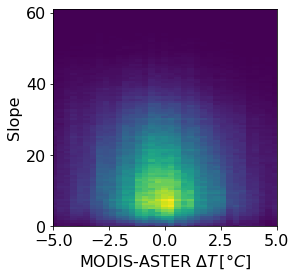

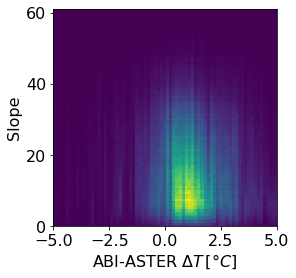

In [30]:
conf = 0.975

y = np.array([ds.dem_slope.values] * len(ds.time)).ravel()

# MODIS-ASTER deltaT
x = ds.ast_mod_mean_diff_tb.values.ravel()
#quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','Slope', conf)
plt.figure(figsize=(4,4))
plt.hist2d(x[~np.isnan(x) & ~np.isnan(y)],y[~np.isnan(x) & ~np.isnan(y)],bins=[200,100]);
plt.xlabel('MODIS-ASTER $\Delta T\,[\degree C]$')
plt.ylabel('Slope');
plt.xlim(-5,5);

# ABI-ASTER deltaT
x = ds.ast_goes_mean_diff_tb.values.ravel()
#quick_plot(x,y,'ABI-ASTER $\Delta T\,[\degree C]$','Slope', conf)
plt.figure(figsize=(4,4))
plt.hist2d(x[~np.isnan(x) & ~np.isnan(y)],y[~np.isnan(x) & ~np.isnan(y)],bins=[200,100]);
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.ylabel('Slope');
plt.xlim(-5,5);

## Absolute value of ABI-ASTER deltaT
#x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
#quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','Slope', conf)

In [31]:
#conf = 0.975
#
#y = ds.dem_slope.values.ravel()
#
## MODIS-ASTER deltaT
#x = ds.ast_mod_mean_diff_tb.mean(axis=0).values.ravel()
#quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','Slope', conf)
#
## ABI-ASTER deltaT
#x = ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel()
#quick_plot(x,y,'ABI-ASTER $\Delta T\,[\degree C]$','Slope', conf)
#
### Absolute value of ABI-ASTER deltaT
##x = np.abs(ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel())
##quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','Slope', conf)
##
#

### sat hillshade

In [32]:
#conf = 0.975
#
#y = ds.sat_hillshade.values.ravel()
#
## MODIS-ASTER deltaT
#x = ds.ast_mod_mean_diff_tb.values.ravel()
#quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','Sat Hillshade', conf)
#
## ABI-ASTER deltaT
#x = ds.ast_goes_mean_diff_tb.values.ravel()
#quick_plot(x,y,'ABI-ASTER $\Delta T\,[\degree C]$','Sat Hillshade', conf)
#
### Absolute value of ABI-ASTER deltaT
##x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
##quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','Sat Hillshade', conf)

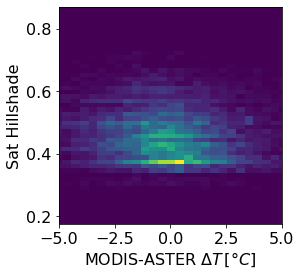

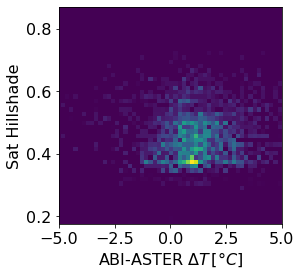

In [33]:
conf = 0.975

y = ds.sat_hillshade_goes_zonal_mean.values.ravel()

# MODIS-ASTER deltaT
x = ds.ast_mod_mean_diff_tb.values.ravel()
#quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','Sat Hillshade', conf)
plt.figure(figsize=(4,4))
plt.hist2d(x[~np.isnan(x) & ~np.isnan(y)],y[~np.isnan(x) & ~np.isnan(y)],bins=[150,50]);
plt.xlabel('MODIS-ASTER $\Delta T\,[\degree C]$')
plt.ylabel('Sat Hillshade');
plt.xlim(-5,5);
#plt.xlim(-2,2)

# ABI-ASTER deltaT
x = ds.ast_goes_mean_diff_tb.values.ravel()
#quick_plot(x,y,'ABI-ASTER $\Delta T\,[\degree C]$','Sat Hillshade', conf)
plt.figure(figsize=(4,4))
plt.hist2d(x[~np.isnan(x) & ~np.isnan(y)],y[~np.isnan(x) & ~np.isnan(y)],bins=[150,50]);
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.ylabel('Sat Hillshade');
plt.xlim(-5,5);
#plt.xlim(-2,2)

## Absolute value of ABI-ASTER deltaT
#x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
#quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','Sat Hillshade', conf)

---

### solar hillshade
(daytime only)

In [34]:
#conf = 0.975
#
#y = ds.where(ds.time.dt.hour == 18).solar_hillshade.values.ravel()
#
## MODIS-ASTER deltaT
#x = ds.where(ds.time.dt.hour == 18).ast_mod_mean_diff_tb.values.ravel()
#quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','Solar Hillshade', conf)
##plt.xlim(-10,10)
#
## ABI-ASTER deltaT
#x = ds.where(ds.time.dt.hour == 18).ast_goes_mean_diff_tb.values.ravel()
#quick_plot(x,y,'ABI-ASTER $\Delta T\,[\degree C]$','Solar Hillshade', conf)
##plt.xlim(-10,10)
#
### Absolute value of ABI-ASTER deltaT
##x = np.abs(ds.where(ds.time.dt.hour == 18).ast_goes_mean_diff_tb.values.ravel())
##quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','Solar Hillshade', conf)

In [35]:
#for i in range(0,len(ds.time)):
#    plt.figure()
#    ds.isel(time=i).solar_hillshade.plot(cmap='Greys_r',vmin=0,vmax=1)
#    plt.savefig(f'tmp{i}.jpg')
#    plt.close()
#    
#!convert -delay 10 tmp*.jpg solar_hillshade_animation.gif

In [36]:
#for i in range(0,len(ds.time)):
#    plt.figure(figsize=(3,3))
#    plt.title(ds.isel(time=i).time.values)
#    plt.plot(ds.isel(time=i).ast_goes_mean_diff_tb.values.ravel(),
#             ds.isel(time=i).solar_hillshade_goes_zonal_mean.values.ravel(),
#             linestyle='none', marker='.', c='k')
#    plt.ylim(0,1)
#    plt.xlim(-20,20)

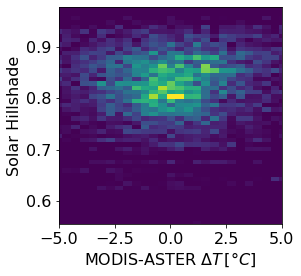

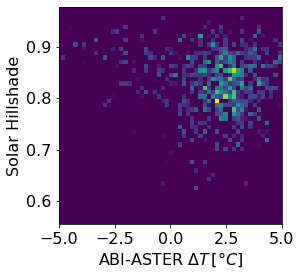

In [37]:
conf = 0.975

y = ds.where(ds.time.dt.hour == 18).solar_hillshade_goes_zonal_mean.values.ravel()

# MODIS-ASTER deltaT
x = ds.where(ds.time.dt.hour == 18).ast_mod_mean_diff_tb.values.ravel()
#quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','Solar Hillshade', conf)
plt.figure(figsize=(4,4))
plt.hist2d(x[~np.isnan(x) & ~np.isnan(y)],y[~np.isnan(x) & ~np.isnan(y)],bins=[150,50]);
plt.xlabel('MODIS-ASTER $\Delta T\,[\degree C]$')
plt.ylabel('Solar Hillshade');
#plt.xlim(-10,10)
plt.xlim(-5,5);

# ABI-ASTER deltaT
x = ds.where(ds.time.dt.hour == 18).ast_goes_mean_diff_tb.values.ravel()
#quick_plot(x,y,'ABI-ASTER $\Delta T\,[\degree C]$','Solar Hillshade', conf)
plt.figure(figsize=(4,4))
plt.hist2d(x[~np.isnan(x) & ~np.isnan(y)],y[~np.isnan(x) & ~np.isnan(y)],bins=[150,50]);
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.ylabel('Solar Hillshade');
#plt.xlim(-10,10)
plt.xlim(-5,5);

## Absolute value of ABI-ASTER deltaT
#x = np.abs(ds.where(ds.time.dt.hour == 18).ast_goes_mean_diff_tb.values.ravel())
#quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','Solar Hillshade', conf)

### DAH

daytime only

In [38]:
#conf = 0.975
#
#y = ds.DAH.values.ravel()
#
## MODIS-ASTER deltaT
#x = ds.where(ds.time.dt.hour == 18).ast_mod_mean_diff_tb.values.ravel()
#quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','DAH', conf)
##plt.xlim(-10,10)
#
## ABI-ASTER deltaT
#x = ds.where(ds.time.dt.hour == 18).ast_goes_mean_diff_tb.values.ravel()
#quick_plot(x,y,'ABI-ASTER $\Delta T\,[\degree C]$','DAH', conf)
##plt.xlim(-10,10)
#
### Absolute value of ABI-ASTER deltaT
##x = np.abs(ds.where(ds.time.dt.hour == 18).ast_goes_mean_diff_tb.values.ravel())
##quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','DAH', conf)

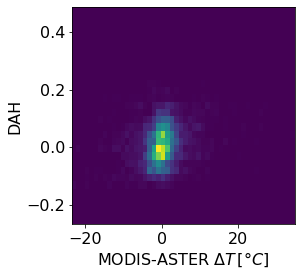

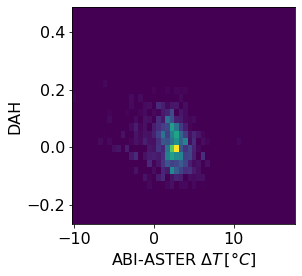

In [39]:
conf = 0.975

y = ds.where(ds.time.dt.hour == 18).DAH_goes_zonal_mean.values.ravel()

# MODIS-ASTER deltaT
x = ds.where(ds.time.dt.hour == 18).ast_mod_mean_diff_tb.values.ravel()
#quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','DAH', conf)
plt.figure(figsize=(4,4))
plt.hist2d(x[~np.isnan(x) & ~np.isnan(y)],y[~np.isnan(x) & ~np.isnan(y)],bins=[50,30]);
plt.xlabel('MODIS-ASTER $\Delta T\,[\degree C]$')
plt.ylabel('DAH');
#plt.xlim(-10,10)
#plt.xlim(-5,5);

# ABI-ASTER deltaT
x = ds.where(ds.time.dt.hour == 18).ast_goes_mean_diff_tb.values.ravel()
#quick_plot(x,y,'ABI-ASTER $\Delta T\,[\degree C]$','DAH', conf)
plt.figure(figsize=(4,4))
plt.hist2d(x[~np.isnan(x) & ~np.isnan(y)],y[~np.isnan(x) & ~np.isnan(y)],bins=[50,30]);
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.ylabel('DAH');
#plt.ylim(-.2,.2)
#plt.xlim(-5,5);

## Absolute value of ABI-ASTER deltaT
#x = np.abs(ds.where(ds.time.dt.hour == 18).ast_goes_mean_diff_tb.values.ravel())
#quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','DAH', conf)

### Aspect

In [40]:
def pol2cart(rho, phi, rotate):
    # given a point's polar coordinates rho (radial distance), phi (clockwise azimuth angle), 
    # and rotate (angle to add to phi to put 0 degrees at the top like a compass)
    #https://stackoverflow.com/questions/20924085/python-conversion-between-coordinates
    x = rho * np.cos(np.radians(-phi+rotate))
    y = rho * np.sin(np.radians(-phi+rotate))
    return(x, y)

(0.0, 6.283185307179586, 0.0, 1.0550000000000004)

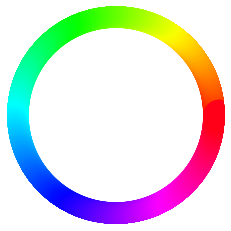

In [41]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

xval = np.arange(0, 2*np.pi, 0.01)
yval = np.ones_like(xval)

colormap = plt.get_cmap('hsv')
norm = mpl.colors.Normalize(0.0, 2*np.pi)

ax = plt.subplot(1,1,1, polar=True)
ax.scatter(xval, yval, c=xval, s=1000, cmap=colormap, norm=norm, linewidths=0)
#ax.set_yticks([])
ax.axis('off')

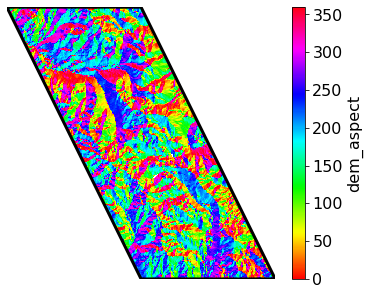

In [42]:
fig, ax = plt.subplots(figsize=(6,5))
ds.dem_aspect.plot(ax=ax, cmap='hsv')
ax.axis('off')
ax.set_title('')
ax.plot([utm_e_UL, utm_e_UR, utm_e_LR, utm_e_LL, utm_e_UL],
                 [utm_n_UL, utm_n_UR, utm_n_LR, utm_n_LL, utm_n_UL],
                 linestyle='-', color='k', lw=3)

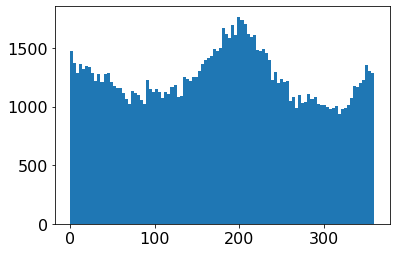

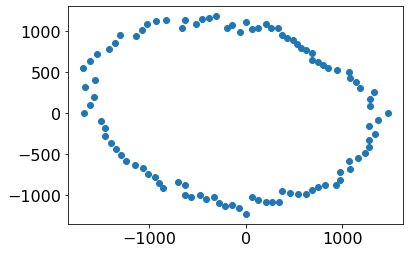

In [43]:
aspect_hist = plt.hist(ds.dem_aspect.values.ravel(),bins=100)

aspect_x, aspect_y = pol2cart(aspect_hist[0],aspect_hist[1][:-1],0)


plt.figure()
plt.scatter(aspect_x, aspect_y)

In [44]:
ds_day = ds.where(ds.time.dt.hour==18)
ds_night = ds.where(ds.time.dt.hour==6)

In [45]:
ds_day = ds.where(ds.time.dt.hour==18, drop=True)
ds_night = ds.where(ds.time.dt.hour==6, drop=True)

In [46]:
azis_all = np.array([ds.dem_aspect.values]*len(ds.time)).ravel() # azimuth angles these are oriented with 0 as south, 180 as north
azis_day = np.array([ds.dem_aspect.values]*len(ds_day.time)).ravel() # azimuth angles these are oriented with 0 as south, 180 as north
azis_night = np.array([ds.dem_aspect.values]*len(ds_night.time)).ravel() # azimuth angles these are oriented with 0 as south, 180 as north
temps_day = ds_day.ast_goes_mean_diff_tb.values.ravel() # ABI temperatures day
temps_night = ds_night.ast_goes_mean_diff_tb.values.ravel() # ABI temperatures night
#temps_day = ds_day.ast_mod_mean_diff_tb.values.ravel() # MODIS temperatures day
#temps_night = ds_night.ast_mod_mean_diff_tb.values.ravel() # MODIS temperatures night

rotate = 90 # rotate 90 for 0 at top, rotate -90 for 0 at bottom 

# for all data
x_day,y_day = pol2cart(temps_day,azis_day,rotate)
x_night,y_night = pol2cart(temps_night,azis_night,rotate) 

# average by 1 degree bins
azis_day_1deg = np.round(azis_day,0)
azis_night_1deg = np.round(azis_night,0)
azis_all_1deg = np.round(azis_all,0)
temps_day_1deg = []
temps_night_1deg = []
counts_1deg = []
for a in range(0,360):
    temps_day_1deg.append(np.nanmean(temps_day[azis_day_1deg == a]))
    temps_night_1deg.append(np.nanmean(temps_night[azis_night_1deg == a]))
    counts_1deg.append(len(azis_all_1deg[azis_all_1deg == a]))

x_day_1deg,y_day_1deg = pol2cart(temps_day_1deg,np.array(range(0,360)),rotate) 
x_night_1deg,y_night_1deg = pol2cart(temps_night_1deg,np.array(range(0,360)),rotate)
x_counts, y_counts = pol2cart(counts_1deg,np.array(range(0,360)),rotate)

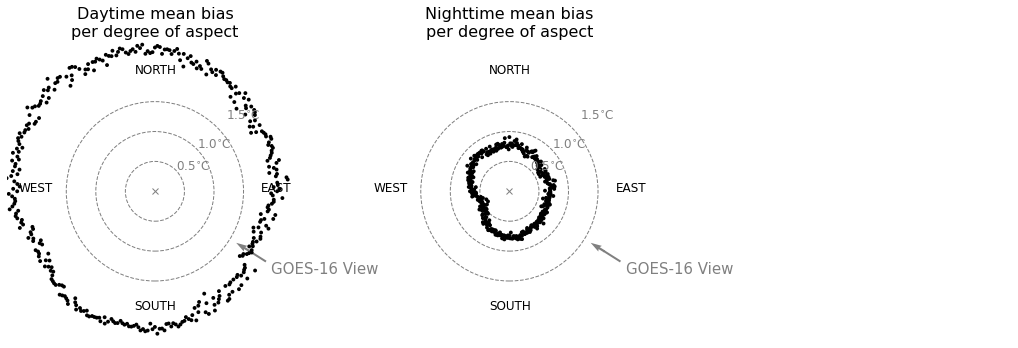

In [47]:





fig, [ax, ax2, ax3] = plt.subplots(1, 3, figsize=(18,5.5))



for each_ax in [ax, ax2]:
    each_ax.plot(0,0,'x',color='grey')
    circle0p5 = plt.Circle((0, 0), radius=0.5, color='grey', fill=False, linestyle='--')
    circle1 = plt.Circle((0, 0), radius=1, color='grey', fill=False, linestyle='--')
    circle1p5 = plt.Circle((0, 0), radius=1.5, color='grey', fill=False, linestyle='--')
    each_ax.add_artist(circle0p5)
    each_ax.add_artist(circle1)
    each_ax.add_artist(circle1p5)


    # SOUTH should be 180
    x_south,y_south = pol2cart(2,190,rotate)
    each_ax.text(x_south,y_south,'SOUTH',fontsize=12)
    
    # EAST should be 90
    x_east,y_east = pol2cart(1.8,90,rotate)
    each_ax.text(x_east,y_east,'EAST',fontsize=12)
    
    # NORTH should be 0
    x_north,y_north = pol2cart(2,350,rotate)
    each_ax.text(x_north,y_north,'NORTH',fontsize=12)
    
    # WEST should be 270
    x_west,y_west = pol2cart(2.3,270,rotate)
    each_ax.text(x_west,y_west ,'WEST',fontsize=12)

    each_ax.text(.35,.35,'0.5$^{\circ}$C',color='grey',fontsize=12)
    each_ax.text(.72,.72,'1.0$^{\circ}$C',color='grey',fontsize=12)
    each_ax.text(1.2,1.2,'1.5$^{\circ}$C',color='grey',fontsize=12)



# DAY
#ax.scatter(x,y,s=5,alpha=0.3,facecolors='tab:gray', edgecolors='none',label='Temperature per 1$^{\circ}$ azimuth bin');
ax.scatter(x_day_1deg,y_day_1deg,s=15,alpha=1,facecolors='k', edgecolors='none',zorder=3,label='Mean Temperature per 1$^{\circ}$ azimuth bin');
#ax.plot(x_1deg,y_1deg,markersize=10,alpha=1, linestyle='-',c='r', zorder=3,label='Mean Temperature per 1$^{\circ}$ azimuth bin');
ax.set_title('Daytime mean bias\nper degree of aspect')

# NIGHT
ax2.scatter(x_night_1deg,y_night_1deg,s=15,alpha=1,facecolors='k', edgecolors='none',zorder=3,label='Mean Temperature per 1$^{\circ}$ azimuth bin');
ax2.set_title('Nighttime')
ax2.set_title('Nighttime mean bias\nper degree of aspect')

# HISTOGRAM (sort of) of AZIMUTHS
#ax3.scatter(x_counts,y_counts,s=15,alpha=1,facecolors='k', edgecolors='none',zorder=3,label='Mean Temperature per 1$^{\circ}$ azimuth bin');
ax3.axis('off')

for each_ax in [ax, ax2]:
    each_ax.set_xlim((-2.5,2.5))
    each_ax.set_ylim((-2.5,2.5))
    each_ax.axis('off')
    # Direction of GOES-16's view is about 122 degrees (when north is 0), but here with south as 0, that is 180+122 = 302
    pointer_loc = 1.9
    length = .3
    sun_x, sun_y = pol2cart(pointer_loc+length,122,rotate)
    sun_x2, sun_y2 = pol2cart(pointer_loc,122,rotate)
    each_ax.quiver(sun_x2,sun_y2,-sun_x2,-sun_y2,color='grey',label='GOES-16 ABI')
    each_ax.plot([sun_x,sun_x2],[sun_y,sun_y2],'-',linewidth='2',color='grey')
    each_ax.text(sun_x+.1, sun_y-.2,'GOES-16 View',fontsize=15,color='grey')

#plt.legend(loc='lower right')
plt.savefig('images/mean_bias_per_degree_aspect_day_night_ASTER-ABI.png',dpi=200)




---

### FSCA

0.011404323168950388 0.5756741261685016 0.03649205894466027 0.0 0.00028700473592284745
using 50% fsca as threshold value:  0.5
number of pixels:  477617 706477
means:  0.8 0.8
mean diff: -0.1
medians:  0.9 0.9


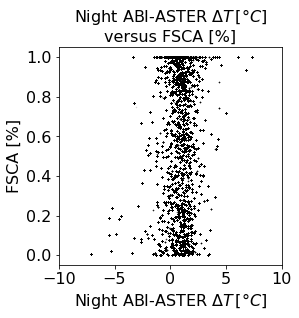

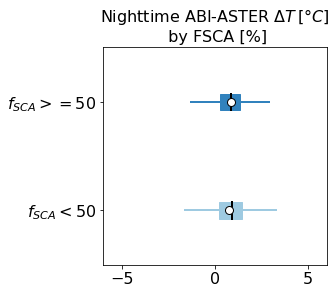

In [275]:

ds_day = ds.where(ds.time.dt.hour>=18, drop=True)
ds_night = ds.where(ds.time.dt.hour<=6, drop=True)

_y = ds_night.fsca.values.ravel()
_y2 = _y[~np.isnan(_y)]
y = _y2[_y2!=0]

## MODIS-ASTER deltaT
#_x = ds_night.ast_mod_mean_diff_tb.values.ravel()
#x = _x[~np.isnan(_y)]
#x = x[_y2!=0]
#quick_plot(x,y,'Night MODIS-ASTER $\Delta T\,[\degree C]$','FSCA [%]', conf, False)

# ABI-ASTER deltaT
_x = ds_night.ast_goes_mean_diff_tb.values.ravel()
x = _x[~np.isnan(_y)]
x = x[_y2!=0]
quick_plot(x,y,'Night ABI-ASTER $\Delta T\,[\degree C]$','FSCA [%]', conf, False)
plt.xlim(-10,10)

## Absolute value of ABI-ASTER deltaT
#x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
#quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','Elevation [m]', conf)

###################################################################################

fsca_threshold = 0.5 #ds.fsca.median().values
print('using 50% fsca as threshold value: ', fsca_threshold)

x_lt = x[y<fsca_threshold]
y_lt = y[y<fsca_threshold]

x_gte = x[y>=fsca_threshold]
y_gte = y[y>=fsca_threshold]

plt.figure(figsize=(4,4))

bplot = plt.boxplot([x_lt, 
                     x_gte],vert=False,
                     showfliers=False, showmeans=True, patch_artist=True,
                     labels=['$f_{SCA}<50%$', '$f_{SCA}>=50%$']);

color1='#9ecae1'
color2='#3182bd'
# fill with colors
colors = [color1, color2]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_edgecolor(color)
    patch.set_facecolor(color)
colors = ['k', 'k']
for patch, color in zip(bplot['medians'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['means'], colors):
    patch.set_markeredgecolor(color)
    patch.set_markerfacecolor('w')
    patch.set_marker('o')
    patch.set_markersize(8)
for patch, color in zip(bplot['fliers'], colors):
    patch.set_markeredgecolor(color)
    patch.set_markersize(1)
    patch.set_marker('.')
colors = [color1, color1, color2, color2]
for patch, color in zip(bplot['whiskers'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['caps'], colors):
    patch.set_color(color)
    patch.set_linewidth(0)
    
    
    
plt.title('Nighttime ABI-ASTER $\Delta T\,[\degree C]$\n by FSCA [%]')
plt.xlim(-6,6);

print('number of pixels: ',len(x_lt),len(x_gte))
print('means: ',np.round(np.mean(x_lt),1),np.round(np.mean(x_gte),1))
print(f'mean diff: {np.round(np.mean(x_lt)-np.mean(x_gte),1)}')
print('medians: ',np.round(np.median(x_lt),1),np.round(np.median(x_gte),1))


x_gte_night = x_gte
x_lt_night = x_lt

0.02624983962988244 0.6657174043412368 0.14609877678310423 0.0 0.00023212801770251915
number of pixels:  130636 455686
means:  1.8 2.5
mean diff: -0.7
medians:  2.3 2.5


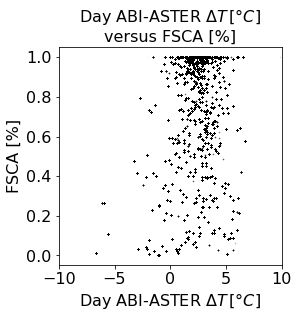

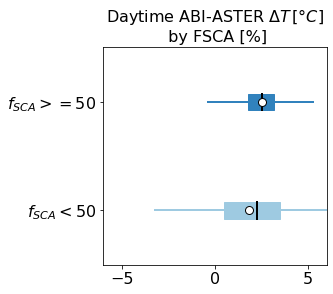

In [276]:

ds_day = ds.where(ds.time.dt.hour>=18, drop=True)
ds_night = ds.where(ds.time.dt.hour<=6, drop=True)

_y = ds_day.fsca.values.ravel()
_y2 = _y[~np.isnan(_y)]
y = _y2[_y2!=0]

## MODIS-ASTER deltaT
#_x = ds_night.ast_mod_mean_diff_tb.values.ravel()
#x = _x[~np.isnan(_y)]
#x = x[_y2!=0]
#quick_plot(x,y,'Night MODIS-ASTER $\Delta T\,[\degree C]$','FSCA [%]', conf, False)

# ABI-ASTER deltaT
_x = ds_day.ast_goes_mean_diff_tb.values.ravel()
x = _x[~np.isnan(_y)]
x = x[_y2!=0]
quick_plot(x,y,'Day ABI-ASTER $\Delta T\,[\degree C]$','FSCA [%]', conf, False)
plt.xlim(-10,10)

## Absolute value of ABI-ASTER deltaT
#x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
#quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','Elevation [m]', conf)

########################################################

x_lt = x[y<fsca_threshold]
y_lt = y[y<.5]

x_gte = x[y>=fsca_threshold]
y_gte = y[y>=fsca_threshold]

plt.figure(figsize=(4,4))

bplot = plt.boxplot([x_lt, 
                     x_gte],vert=False,
                     showfliers=False, showmeans=True, patch_artist=True,
                     labels=['$f_{SCA}<50%$', '$f_{SCA}>=50%$']);

color1='#9ecae1'
color2='#3182bd'
# fill with colors
colors = [color1, color2]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_edgecolor(color)
    patch.set_facecolor(color)
colors = ['k', 'k']
for patch, color in zip(bplot['medians'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['means'], colors):
    patch.set_markeredgecolor(color)
    patch.set_markerfacecolor('w')
    patch.set_marker('o')
    patch.set_markersize(8)
for patch, color in zip(bplot['fliers'], colors):
    patch.set_markeredgecolor(color)
    patch.set_markersize(1)
    patch.set_marker('.')
colors = [color1, color1, color2, color2]
for patch, color in zip(bplot['whiskers'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['caps'], colors):
    patch.set_color(color)
    patch.set_linewidth(0)
    
    
    
plt.title('Daytime ABI-ASTER $\Delta T\,[\degree C]$\n by FSCA [%]')
plt.xlim(-6,6);

print('number of pixels: ',len(x_lt),len(x_gte))
print('means: ',np.round(np.mean(x_lt),1),np.round(np.mean(x_gte),1))
print(f'mean diff: {np.round(np.mean(x_lt)-np.mean(x_gte),1)}')
print('medians: ',np.round(np.median(x_lt),1),np.round(np.median(x_gte),1))


x_gte_day = x_gte
x_lt_day = x_lt

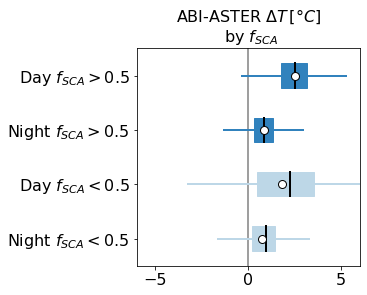

In [277]:
plt.figure(figsize=(4,4))

bplot = plt.boxplot([x_lt_night, x_lt_day, 
                     x_gte_night, x_gte_day],vert=False,
                     showfliers=False, showmeans=True, patch_artist=True,
                     labels=['Night $f_{SCA}<0.5$','Day $f_{SCA}<0.5$', 'Night $f_{SCA}>0.5$', 'Day $f_{SCA}>0.5$']);

plt.axvline(0,linestyle='-',color='grey', zorder=-99)

color1='#bdd7e7'
color2='#3182bd'
# fill with colors
colors = [color1, color1, color2, color2]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_edgecolor(color)
    patch.set_facecolor(color)
colors = ['k', 'k', 'k', 'k']
for patch, color in zip(bplot['medians'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['means'], colors):
    patch.set_markeredgecolor(color)
    patch.set_markerfacecolor('w')
    patch.set_marker('o')
    patch.set_markersize(8)
for patch, color in zip(bplot['fliers'], colors):
    patch.set_markeredgecolor(color)
    patch.set_markersize(1)
    patch.set_marker('.')
colors = [color1, color1, color1, color1, color2, color2, color2, color2]
for patch, color in zip(bplot['whiskers'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['caps'], colors):
    patch.set_color(color)
    patch.set_linewidth(0)
    
    
    
plt.title('ABI-ASTER $\Delta T\,[\degree C]$\n by $f_{SCA}$')
plt.xlim(-6,6);


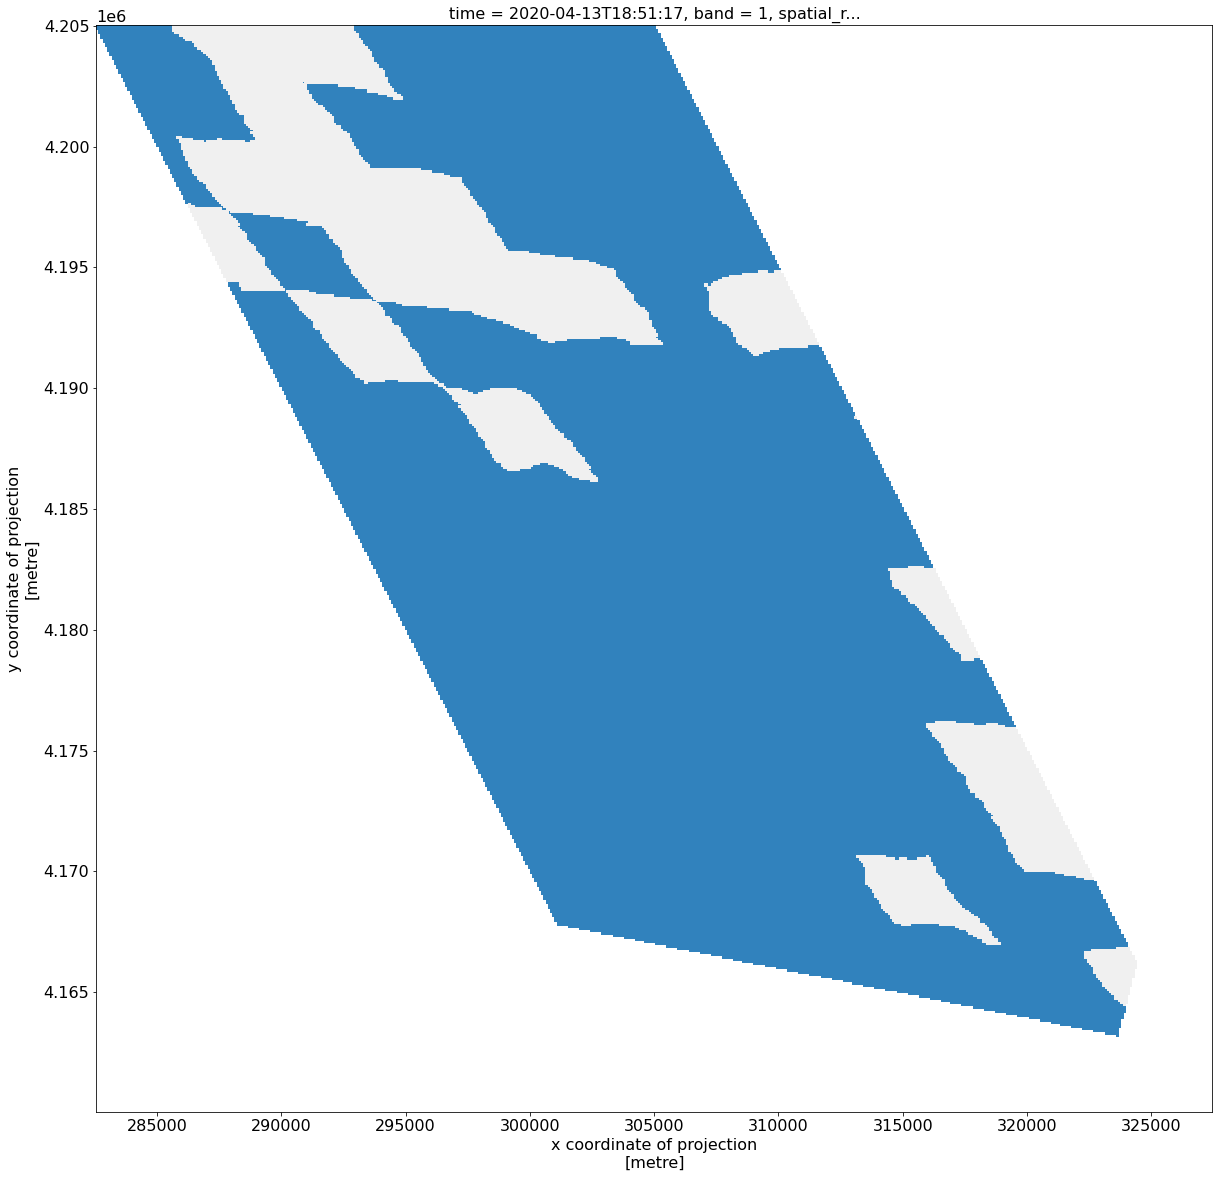

In [278]:
k = fsca_threshold
i = 24

# blue
blue_cmap = ListedColormap(['#3182bd'])

# grey
grey_cmap = ListedColormap(['#f0f0f0'])

plt.figure(figsize=(20,20))
# green
ds.ast_goes_aster_rad2tbK.where(ds.fsca > k).isel(time=i).plot(add_colorbar=False,vmin=500,vmax=501,cmap=blue_cmap)
# grey
ds.ast_goes_aster_rad2tbK.where(ds.fsca <= k).isel(time=i).plot(add_colorbar=False,vmin=500,vmax=501,cmap=grey_cmap)


---
### Fveg, separate day/night

using median fveg as threshold value:  0.16026871401151632
DAY
number of pixels:  303039 300980
means:  2.2 2.3
mean diff: -0.1
medians:  2.4 2.6
NIGHT
number of pixels:  674651 676496
means:  0.7 0.8
mean diff: -0.1
medians:  0.7 0.9


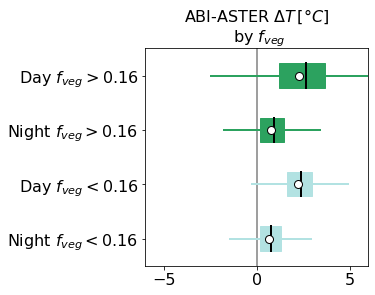

In [280]:

fveg_threshold = ds.fveg.median().values
print('using median fveg as threshold value: ', fveg_threshold)

ds_day = ds.where(ds.time.dt.hour>=18, drop=True)
ds_night = ds.where(ds.time.dt.hour<=6, drop=True)
#
y = ds_day.fveg.values.ravel()#np.array([ds.fveg.values] * 27).ravel()
#
## MODIS-ASTER deltaT
#x = ds_day.ast_mod_mean_diff_tb.values.ravel()
#x0 = x#[y!=0]
#y0 = y#[y!=0]
#quick_plot(x0,y0,'Day MODIS-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)
#
# ABI-ASTER deltaT
x = ds_day.ast_goes_mean_diff_tb.values.ravel()
x0 = x#[y!=0]
y0 = y#[y!=0]
#quick_plot(x0,y0,'Day ABI-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)
#

x_lt = x0[y0<=fveg_threshold]
y_lt = y0[y0<=fveg_threshold]
x_gte = x0[y0>fveg_threshold]
y_gte = y0[y0>fveg_threshold]
x_gte_day = x_gte
x_lt_day = x_lt

print('DAY')
print('number of pixels: ',len(x_lt),len(x_gte))
print('means: ',np.round(np.mean(x_lt),1),np.round(np.mean(x_gte),1))
print(f'mean diff: {np.round(np.mean(x_lt)-np.mean(x_gte),1)}')
print('medians: ',np.round(np.median(x_lt),1),np.round(np.median(x_gte),1))


#################################################
#
y = ds_night.fveg.values.ravel()#np.array([ds.fveg.values] * 27).ravel()
## MODIS-ASTER deltaT
#x = ds_night.ast_mod_mean_diff_tb.values.ravel()
#x0 = x#[y!=0]
#y0 = y#[y!=0]
#quick_plot(x0,y0,'Night MODIS-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)
#
# ABI-ASTER deltaT
x = ds_night.ast_goes_mean_diff_tb.values.ravel()
x0 = x#[y!=0]
y0 = y#[y!=0]
#quick_plot(x0,y0,'Night ABI-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)
#


x_lt = x0[y0<=fveg_threshold]
y_lt = y0[y0<=fveg_threshold]
x_gte = x0[y0>fveg_threshold]
y_gte = y0[y0>fveg_threshold]
x_gte_night = x_gte
x_lt_night = x_lt

print('NIGHT')
print('number of pixels: ',len(x_lt),len(x_gte))
print('means: ',np.round(np.mean(x_lt),1),np.round(np.mean(x_gte),1))
print(f'mean diff: {np.round(np.mean(x_lt)-np.mean(x_gte),1)}')
print('medians: ',np.round(np.median(x_lt),1),np.round(np.median(x_gte),1))

#
### Absolute value of ABI-ASTER deltaT
##x = np.abs(ds_day.ast_goes_mean_diff_tb.values.ravel())
##quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','$F_{veg}$', conf)
#
#
#########################################

#y = ds.fveg.values.ravel()#np.array([ds.fveg.values] * 27).ravel()
#
#
## MODIS-ASTER deltaT
#x = ds.ast_mod_mean_diff_tb.values.ravel()
#x0 = x#[y!=0]
#y0 = y#[y!=0]
#quick_plot(x0,y0,' MODIS-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)
#
## ABI-ASTER deltaT
#x = ds.ast_goes_mean_diff_tb.values.ravel()
#x0 = x#[y!=0]
#y0 = y#[y!=0]
#quick_plot(x0,y0,'ABI-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)
#
#
### Absolute value of ABI-ASTER deltaT
##x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
##quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','$F_{veg}$', conf, False)
#

plt.figure(figsize=(4,4))

bplot = plt.boxplot([x_lt_night, x_lt_day, 
                     x_gte_night, x_gte_day],vert=False,
                     showfliers=False, showmeans=True, patch_artist=True,
                     labels=['Night $f_{veg}<0.16$','Day $f_{veg}<0.16$', 
                             'Night $f_{veg}>0.16$', 'Day $f_{veg}>0.16$']);

plt.axvline(0,linestyle='-',color='grey', zorder=-99)

color2='#2ca25f'
color1='#b2e2e2'
# fill with colors
colors = [color1, color1, color2, color2]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_edgecolor(color)
    patch.set_facecolor(color)
colors = ['k', 'k', 'k', 'k']
for patch, color in zip(bplot['medians'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['means'], colors):
    patch.set_markeredgecolor(color)
    patch.set_markerfacecolor('w')
    patch.set_marker('o')
    patch.set_markersize(8)
for patch, color in zip(bplot['fliers'], colors):
    patch.set_markeredgecolor(color)
    patch.set_markersize(1)
    patch.set_marker('.')
colors = [color1, color1, color1, color1, color2, color2, color2, color2]
for patch, color in zip(bplot['whiskers'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['caps'], colors):
    patch.set_color(color)
    patch.set_linewidth(0)
    
    
    
plt.title('ABI-ASTER $\Delta T\,[\degree C]$\n by $f_{veg}$')
plt.xlim(-6,6);

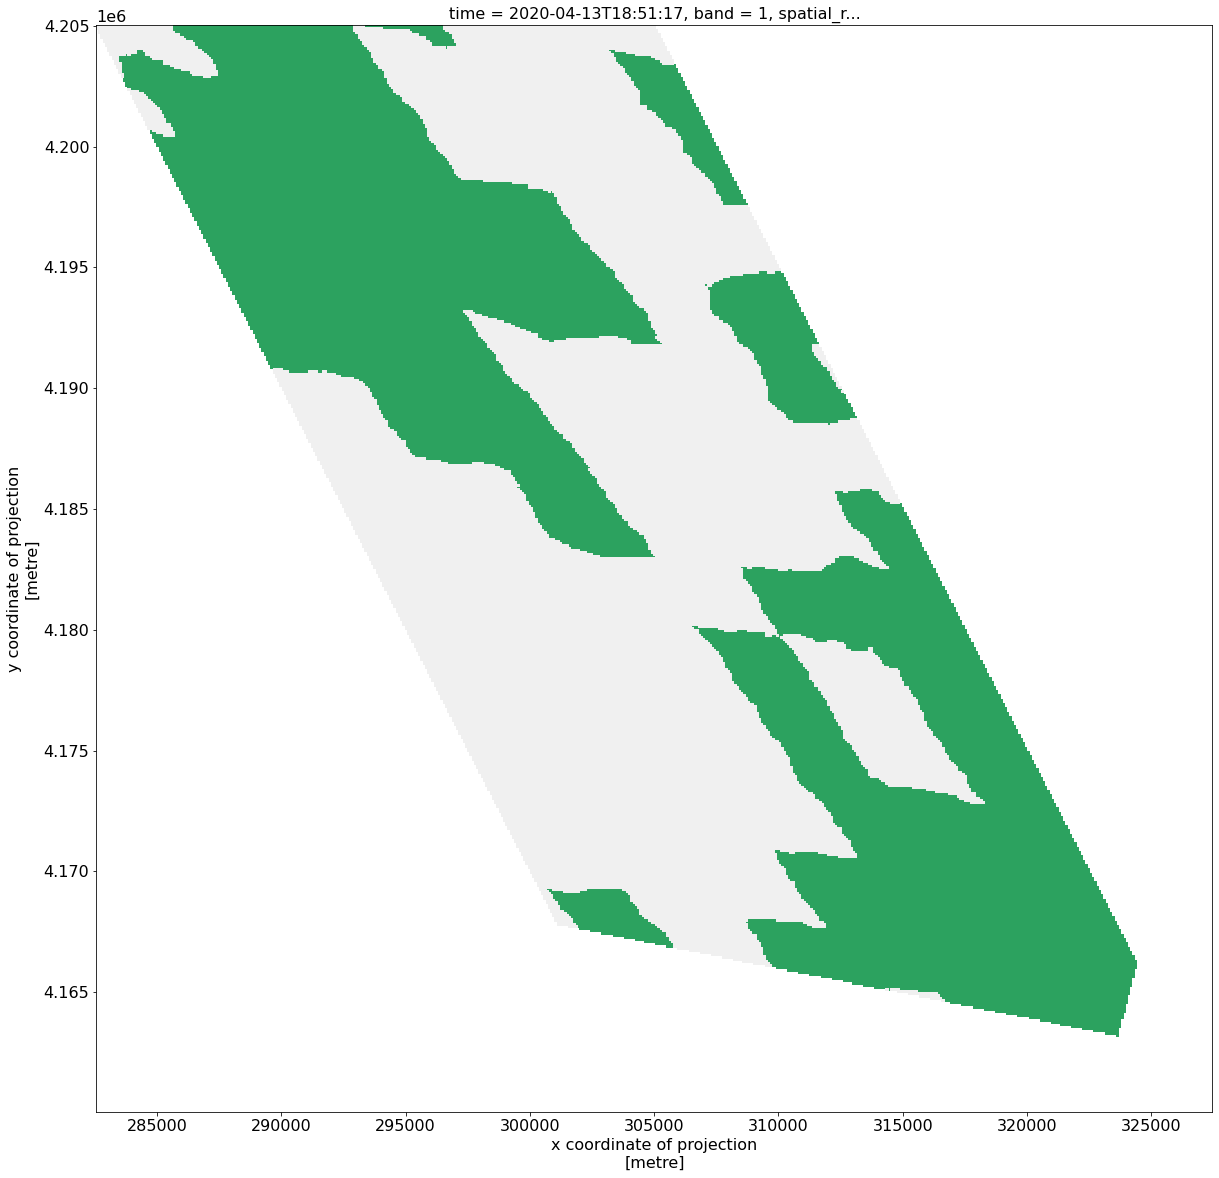

In [281]:
k = fveg_threshold

# green
green_cmap = ListedColormap(['#2ca25f'])

# grey
grey_cmap = ListedColormap(['#f0f0f0'])

plt.figure(figsize=(20,20))
# green
ds.ast_goes_aster_rad2tbK.where(ds.fveg > k).isel(time=i).plot(add_colorbar=False,vmin=500,vmax=501,cmap=green_cmap)
# grey
ds.ast_goes_aster_rad2tbK.where(ds.fveg <= k).isel(time=i).plot(add_colorbar=False,vmin=500,vmax=501,cmap=grey_cmap)


In [52]:
#
#
#ds_day = ds.where(ds.time.dt.hour==18, drop=True)
#ds_night = ds.where(ds.time.dt.hour==6, drop=True)
#
#y = ds_day.fveg.mean(axis=0).values.ravel()
#
#
## MODIS-ASTER deltaT
#x = ds_day.ast_mod_mean_diff_tb.mean(axis=0).values.ravel()
#x0 = x#[y!=0]
#y0 = y#[y!=0]
#quick_plot(x0,y0,'Day MODIS-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)
#
## ABI-ASTER deltaT
#x = ds_day.ast_goes_mean_diff_tb.mean(axis=0).values.ravel()
#x0 = x#[y!=0]
#y0 = y#[y!=0]
#quick_plot(x0,y0,'Day ABI-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)
#
#######################################
#
#
#y = ds_night.fveg.mean(axis=0).values.ravel()
#
#
## MODIS-ASTER deltaT
#x = ds_night.ast_mod_mean_diff_tb.mean(axis=0).values.ravel()
#x0 = x#[y!=0]
#y0 = y#[y!=0]
#quick_plot(x0,y0,'Night MODIS-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)
#
## ABI-ASTER deltaT
#x = ds_night.ast_goes_mean_diff_tb.mean(axis=0).values.ravel()
#x0 = x#[y!=0]
#y0 = y#[y!=0]
#quick_plot(x0,y0,'Night ABI-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)
#
#
#
#
##################
#
#
#y = ds.fveg.mean(axis=0).values.ravel()
#
#
## MODIS-ASTER deltaT
#x = ds.ast_mod_mean_diff_tb.mean(axis=0).values.ravel()
#x0 = x#[y!=0]
#y0 = y#[y!=0]
#quick_plot(x0,y0,' MODIS-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)
#
## ABI-ASTER deltaT
#x = ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel()
#x0 = x#[y!=0]
#y0 = y#[y!=0]
#quick_plot(x0,y0,'ABI-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)
#
#
### Absolute value of ABI-ASTER deltaT
##x = np.abs(ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel())
##quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','$F_{veg}$', conf, False)
#
#

In [53]:
def quick_plot2(x,y,x_label,y_label, conf, add_linear_regression=True, c='k', m='o', s=15, cmap='RdBu_r',vmin=-10,vmax=10,alpha=0.5):
    plt.figure(figsize=(4,4))
    if type(c)==str:
        plt.scatter(x,y,marker=m,c=c,alpha=alpha,s=s)
    else:
        plt.scatter(x,y,marker=m,c=c,alpha=alpha,s=s,cmap=cmap,vmin=vmin,vmax=vmax)
    _x = x#[~np.isnan(x)]
    _y = y#[~np.isnan(x)]
    slope, intercept, r, p, se = stats.linregress(_x, _y)
    print(np.round(slope,2), '\t', np.round(intercept,2), '\t', np.round(r*r,2), '\t', np.round(p,5), '\t', np.round(se,2))
    if add_linear_regression == True:
        plt.plot(np.linspace(_x.min(),_x.max()),
                 slope*np.linspace(_x.min(),_x.max())+intercept,
                 '--r',zorder=99)
        plot_regression_confidence_intervals(_x,_y,conf)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(f'{x_label}\nversus {y_label}')
    return None

-0.01 	 0.24 	 0.05 	 0.27496 	 0.01
small variations in fveg because of slightly different extents of study area covered


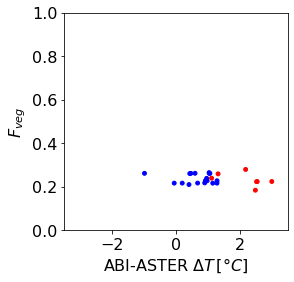

In [54]:
conf = 0.975

ds_day = ds.where(ds.time.dt.hour>=18, drop=True)
ds_night = ds.where(ds.time.dt.hour<=6, drop=True)

day_night = ['b' if x==True else 'r' for x in (ds.time.dt.hour<=6).values ]

# All ABI-ASTER deltaT vs fveg
_y = ds.fveg.mean(dim=['y','x']).values.ravel()
_x = ds.ast_goes_mean_diff_tb.mean(dim=['y','x']).values.ravel()
y = _y[~np.isnan(_x)&~np.isnan(_y)]
x = _x[~np.isnan(_x)&~np.isnan(_y)]
x0 = x#[y!=0]
y0 = y#[y!=0]
quick_plot2(x0,y0,'ABI-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False, day_night, alpha=1) #
plt.title('')
plt.ylim(0,1)
plt.xlim(-3.5,3.5)


## Day ABI-ASTER deltaT vs fveg
#_y = ds_day.fveg.mean(dim=['y','x']).values.ravel()
#_x = ds_day.ast_goes_mean_diff_tb.mean(dim=['y','x']).values.ravel()
#y = _y[~np.isnan(_x)&~np.isnan(_y)]
#x = _x[~np.isnan(_x)&~np.isnan(_y)]
#x0 = x#[y!=0]
#y0 = y#[y!=0]
#quick_plot2(x0,y0,'Day ABI-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False, 'r', alpha=1) #
#plt.title('')
#plt.ylim(0,1)
#plt.xlim(-3,3)
#
## Night ABI-ASTER deltaT vs fveg
#_y = ds_night.fveg.mean(dim=['y','x']).values.ravel()
#_x = ds_night.ast_goes_mean_diff_tb.mean(dim=['y','x']).values.ravel()
#y = _y[~np.isnan(_x)&~np.isnan(_y)]
#x = _x[~np.isnan(_x)&~np.isnan(_y)]
#x0 = x#[y!=0]
#y0 = y#[y!=0]
#quick_plot2(x0,y0,'Night ABI-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False, 'b', alpha=1) #
#plt.title('')
#plt.ylim(0,1)
#plt.xlim(-3,3)
#
print('small variations in fveg because of slightly different extents of study area covered')

In [55]:
#conf = 0.975
#
#for i in range(0,len(ds.time)):
#
#    this_ds = ds.isel(time=i)
#    
#    if this_ds.time.dt.hour  <= 6:
#        c = 'b' # nighttime
#    else:
#        c = 'r' # daytime
#    
#    y = this_ds.fveg.values.ravel()
#    
#    
#    ## MODIS-ASTER deltaT
#    #x = this_ds.ast_mod_mean_diff_tb.mean(axis=0).values.ravel()
#    #x0 = x#[y!=0]
#    #y0 = y#[y!=0]
#    #quick_plot2(x0,y0,'MODIS-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False, c)
#    #plt.ylim(0,1)
#    #plt.xlim(-10,10)
#    # ABI-ASTER deltaT
#    x = this_ds.ast_goes_mean_diff_tb.values.ravel()
#    x0 = x#[y!=0]
#    y0 = y#[y!=0]
#    quick_plot2(x0,y0,'Day ABI-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False, c) #
#    plt.title(this_ds.time.values)
#    plt.ylim(0,1)
#    #plt.xlim(-10,10)

0.12 	 0.44 	 0.49 	 9e-05 	 0.02


(-3.5, 3.5)

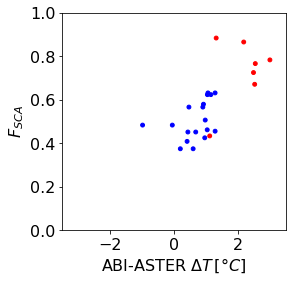

In [56]:
conf = 0.975

ds_day = ds.where(ds.time.dt.hour>=18, drop=True)
ds_night = ds.where(ds.time.dt.hour<=6, drop=True)

day_night = ['b' if x==True else 'r' for x in (ds.time.dt.hour<=6).values ]

# All ABI-ASTER deltaT vs fSCA
_y = ds.binary_snow_gt50.mean(dim=['y','x']).values.ravel()
_x = ds.ast_goes_mean_diff_tb.mean(dim=['y','x']).values.ravel()
y = _y[~np.isnan(_x)&~np.isnan(_y)]
x = _x[~np.isnan(_x)&~np.isnan(_y)]
x0 = x#[y!=0]
y0 = y#[y!=0]
quick_plot2(x0,y0,'ABI-ASTER $\Delta T\,[\degree C]$','$F_{SCA}$', conf, False, day_night, alpha=1) #
plt.title('')
plt.ylim(0,1)
plt.xlim(-3.5,3.5)

#fig,ax = plt.subplots()
#ds.fsca.mean(dim=['y','x']).plot(ax=ax)
#fig,ax = plt.subplots()
#ds.ast_goes_mean_diff_tb.mean(dim=['y','x']).plot(ax=ax)

## Day ABI-ASTER deltaT vs fSCA
#_y = ds_day.fsca.mean(dim=['y','x']).values.ravel()
#_x = ds_day.ast_goes_mean_diff_tb.mean(dim=['y','x']).values.ravel()
#y = _y[~np.isnan(_x)&~np.isnan(_y)]
#x = _x[~np.isnan(_x)&~np.isnan(_y)]
#x0 = x#[y!=0]
#y0 = y#[y!=0]
#quick_plot2(x0,y0,'Day ABI-ASTER $\Delta T\,[\degree C]$','$F_{SCA}$', conf, False, 'r', alpha=1) #
#plt.title('')
#plt.ylim(0,1)
#plt.xlim(-3,3)
#
## Night ABI-ASTER deltaT vs fSCA
#_y = ds_night.fsca.mean(dim=['y','x']).values.ravel()
#_x = ds_night.ast_goes_mean_diff_tb.mean(dim=['y','x']).values.ravel()
#y = _y[~np.isnan(_x)&~np.isnan(_y)]
#x = _x[~np.isnan(_x)&~np.isnan(_y)]
#x0 = x#[y!=0]
#y0 = y#[y!=0]
#quick_plot2(x0,y0,'Night ABI-ASTER $\Delta T\,[\degree C]$','$F_{SCA}$', conf, False, 'b', alpha=1) #
#plt.title('')
#plt.ylim(0,1)
#plt.xlim(-3,3)

In [57]:
#conf = 0.975
#
#for i in range(0,len(ds.time)):
#
#    this_ds = ds.isel(time=i)
#    
#    if this_ds.time.dt.hour  <= 6:
#        c = 'b' # nighttime
#    else:
#        c = 'r' # daytime
#    
#    y = this_ds.fsca.values.ravel()
#    
#    
#    ## MODIS-ASTER deltaT
#    #x = this_ds.ast_mod_mean_diff_tb.mean(axis=0).values.ravel()
#    #x0 = x#[y!=0]
#    #y0 = y#[y!=0]
#    #quick_plot2(x0,y0,'MODIS-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False, c)
#    #plt.ylim(0,1)
#    #plt.xlim(-10,10)
#    # ABI-ASTER deltaT
#    x = this_ds.ast_goes_mean_diff_tb.values.ravel()
#    x0 = x#[y!=0]
#    y0 = y#[y!=0]
#    quick_plot2(x0,y0,'Day ABI-ASTER $\Delta T\,[\degree C]$','$F_{SCA}$', conf, False, c) #
#    plt.title(this_ds.time.values)
#    plt.ylim(0,1)
#    #plt.xlim(-10,10)

In [58]:
#ds_day.binary_snow_gt50.mean(dim=['y','x']).values.ravel()

Multivariate relationships?

In [59]:
#conf = 0.975
#
#ds_day = ds.where(ds.time.dt.hour==18, drop=True)
#ds_night = ds.where(ds.time.dt.hour==6, drop=True)
#
#
#_y = ds.fveg.mean(dim=['y','x']).values.ravel()
#_y2 = ds.fsca.mean(dim=['y','x']).values.ravel()
#_x = ds.ast_goes_mean_diff_tb.mean(dim=['y','x']).values.ravel()
## remove nans
#y = _y[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)]
#y2 = _y2[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)]
#x = _x[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)]
#
#quick_plot2(y,y2,'$F_{veg}$','$F_{SCA}$', conf, False, x, 'o', 25, 'RdBu_r', -3, 3, 1) #
#plt.title('All')
#plt.ylim(-0.1,1.1)
#plt.xlim(-0.1,1.1)
#plt.colorbar()
##plt.xlim(-10,10)
#
#
####
#    
#_y = ds_day.mean(dim=['y','x']).fveg.values.ravel()
#_y2 = ds_day.mean(dim=['y','x']).fsca.values.ravel()
#_x = ds_day.mean(dim=['y','x']).ast_goes_mean_diff_tb.values.ravel()
## remove nans
#y = _y[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)]
#y2 = _y2[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)]
#x = _x[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)]
#
#quick_plot2(y,y2,'$F_{veg}$','$F_{SCA}$', conf, False, x, 'o', 25, 'RdBu_r', -3, 3, 1) #
#plt.title('Day')
#plt.ylim(-0.1,1.1)
#plt.xlim(-0.1,1.1)
#plt.colorbar()
##plt.xlim(-10,10)
#
#
####
#
#_y = ds_night.mean(dim=['y','x']).fveg.values.ravel()
#_y2 = ds_night.mean(dim=['y','x']).fsca.values.ravel()
#_x = ds_night.mean(dim=['y','x']).ast_goes_mean_diff_tb.values.ravel()
## remove nans
#y = _y[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)]
#y2 = _y2[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)]
#x = _x[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)]
#
#quick_plot2(y,y2,'$F_{veg}$','$F_{SCA}$', conf, False, x, 'o', 25, 'RdBu_r', -3, 3, 1) #
#plt.title('Night')
#plt.ylim(-0.1,1.1)
#plt.xlim(-0.1,1.1)
#plt.colorbar()
##plt.xlim(-10,10)

What about a multiple linear regression?

In [60]:
#_y = ds_day.fveg.values.ravel()
#_y2 = ds_day.fsca.values.ravel()
#_x = ds_day.ast_goes_mean_diff_tb.values.ravel()
## remove nans
#y = _y[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)]
#y2 = _y2[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)]
#x = _x[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)]
#
## create the input array
#multi_input = np.array([y, y2, np.ones_like(x)]).T # Transform this array with ".T" to swap rows and columns
#
## Show the shapes of our two inputs to the lstsq function to make sure they have the same first dimension length
#print(multi_input.shape)
#print(x.shape)
#
#
#
#B, resid, _, _ = lstsq(multi_input, x) # I'm using "_" as a placeholder for the outputs I don't need
#print(B)
#print('mean squared error', resid/len(x))
#print('root mean squared error', np.sqrt(resid/len(x)))
#
#
#deltaT_pred = y*B[0] + y2*B[1]+ B[2]
#print('rmse: ',np.sqrt(np.mean((deltaT_pred - x)**2)))
#
#
#fveg_0_to_1, fsca_0_to_1 = np.mgrid[0:100, 0:100]
#deltaT_pred_0_to_1 = fveg_0_to_1/100*B[0] + fsca_0_to_1/100*B[1]+ B[2]
#plt.figure(figsize=(5,4))
#plt.pcolormesh(deltaT_pred_0_to_1.T, vmin=-3, vmax=3, cmap='RdBu_r')
#plt.colorbar()
#plt.xlabel('fveg %')
#plt.ylabel('fsca %')
#plt.title('day')
#
#plt.figure()
#plt.plot(x,y,linestyle='none', marker='.', alpha=0.02)
#plt.plot(deltaT_pred,y,linestyle='none', marker='.', alpha=0.2)
#plt.title('fveg vs dT')
#
#plt.xlim(-5,5)
#
#plt.figure()
#plt.plot(x,y2,linestyle='none', marker='.', alpha=0.02)
#plt.plot(deltaT_pred,y2,linestyle='none', marker='.', alpha=0.2)
#plt.title('fsca vs dT')
#
#plt.xlim(-5,5)

In [61]:
### Including elevation in the model (NIGHT)
#
#_y = ds_night.fveg.values.ravel()
#_y2 = ds_night.fsca.values.ravel()
#_y3 = ds_night.dem.values.ravel()
#_x = ds_night.ast_goes_mean_diff_tb.values.ravel()
## remove nans
#y = _y[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)&~np.isnan(_y3)]
#y2 = _y2[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)&~np.isnan(_y3)]
#y3 = _y3[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)&~np.isnan(_y3)]
#x = _x[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)&~np.isnan(_y3)]
#
## create the input array
#multi_input = np.array([y, y2, y3, np.ones_like(x)]).T # Transform this array with ".T" to swap rows and columns
#
## Show the shapes of our two inputs to the lstsq function to make sure they have the same first dimension length
#print(multi_input.shape)
#print(x.shape)
#
#
#
#B, resid, _, _ = lstsq(multi_input, x) # I'm using "_" as a placeholder for the outputs I don't need
#print(B)
#print('mean squared error', resid/len(x))
#print('root mean squared error', np.sqrt(resid/len(x)))
#
#
#deltaT_pred = y*B[0] + y2*B[1]+ y3*B[2] + B[3]
#print('rmse: ',np.sqrt(np.mean((deltaT_pred - x)**2)))
#
#
#fveg_0_to_1, fsca_0_to_1, elev_0_to_4000 = np.mgrid[0:100, 0:100, 0:4000]
#deltaT_pred_0_to_1 = fveg_0_to_1/100*B[0] + fsca_0_to_1/100*B[1]+ elev_0_to_4000*B[2] + B[3]
#plt.figure(figsize=(5,4))
#plt.pcolormesh(deltaT_pred_0_to_1.T[3000], vmin=-3, vmax=3, cmap='RdBu_r')
#plt.colorbar()
#plt.xlabel('fveg %')
#plt.ylabel('fsca %')
#plt.title('day')
#
##plt.figure()
##plt.plot(x,y,linestyle='none', marker='.', alpha=0.02)
##plt.plot(deltaT_pred,y,linestyle='none', marker='.', alpha=0.2)
##plt.title('fveg vs dT')
##
##plt.xlim(-5,5)
##
##plt.figure()
##plt.plot(x,y2,linestyle='none', marker='.', alpha=0.02)
##plt.plot(deltaT_pred,y2,linestyle='none', marker='.', alpha=0.2)
##plt.title('fsca vs dT')
##
##plt.xlim(-5,5)

In [62]:
### Including elevation in the model  (Day)
#
#_y = ds_day.fveg.values.ravel()
#_y2 = ds_day.fsca.values.ravel()
#_y3 = ds_day.dem.values.ravel()
#_x = ds_day.ast_goes_mean_diff_tb.values.ravel()
## remove nans
#y = _y[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)&~np.isnan(_y3)]
#y2 = _y2[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)&~np.isnan(_y3)]
#y3 = _y3[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)&~np.isnan(_y3)]
#x = _x[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)&~np.isnan(_y3)]
#
## create the input array
#multi_input = np.array([y, y2, y3, np.ones_like(x)]).T # Transform this array with ".T" to swap rows and columns
#
## Show the shapes of our two inputs to the lstsq function to make sure they have the same first dimension length
#print(multi_input.shape)
#print(x.shape)
#
#
#
#B, resid, _, _ = lstsq(multi_input, x) # I'm using "_" as a placeholder for the outputs I don't need
#print(B)
#print('mean squared error', resid/len(x))
#print('root mean squared error', np.sqrt(resid/len(x)))
#
#
#deltaT_pred = y*B[0] + y2*B[1]+ y3*B[2] + B[3]
#print('rmse: ',np.sqrt(np.mean((deltaT_pred - x)**2)))
#
#
#fveg_0_to_1, fsca_0_to_1, elev_0_to_4000 = np.mgrid[0:100, 0:100, 0:4000]
#deltaT_pred_0_to_1 = fveg_0_to_1/100*B[0] + fsca_0_to_1/100*B[1]+ elev_0_to_4000*B[2] + B[3]
#plt.figure(figsize=(5,4))
#plt.pcolormesh(deltaT_pred_0_to_1.T[3000], vmin=-3, vmax=3, cmap='RdBu_r')
#plt.colorbar()
#plt.xlabel('fveg %')
#plt.ylabel('fsca %')
#plt.title('day')
#
##plt.figure()
##plt.plot(x,y,linestyle='none', marker='.', alpha=0.02)
##plt.plot(deltaT_pred,y,linestyle='none', marker='.', alpha=0.2)
##plt.title('fveg vs dT')
##
##plt.xlim(-5,5)
##
##plt.figure()
##plt.plot(x,y2,linestyle='none', marker='.', alpha=0.02)
##plt.plot(deltaT_pred,y2,linestyle='none', marker='.', alpha=0.2)
##plt.title('fsca vs dT')
##
##plt.xlim(-5,5)

Can I use this fveg/fsca/elevation model to apply a correction?

In [63]:
#i = 26
#
#test_y = ds.isel(time=i).fveg
#test_y2 = ds.isel(time=i).fsca
#test_y3 = ds.isel(time=i).dem
#
#correction = test_y*B[0] + test_y2*B[1]+ test_y3*B[2] + B[3]
#
#corrected = ds.isel(time=i).ast_goes_goes_tb - correction
#
#plt.figure()
#a = ds.isel(time=i).ast_goes_goes_tb - ds.isel(time=i).ast_goes_mean_rad2tbK
#a.plot(cmap='RdBu_r',vmin=-5,vmax=5)
#plt.figure()
#a.plot.hist()
#plt.xlim(-5,5)
#
#plt.figure()
#b = corrected - ds.isel(time=i).ast_goes_mean_rad2tbK
#b.plot(cmap='RdBu_r',vmin=-5,vmax=5)
#plt.figure()
#b.plot.hist()
#plt.xlim(-5,5)

In [64]:
#_y = ds_night.fveg.values.ravel()
#_y2 = ds_night.fsca.values.ravel()
#_x = ds_night.ast_goes_mean_diff_tb.values.ravel()
## remove nans
#y = _y[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)]
#y2 = _y2[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)]
#x = _x[~np.isnan(_x)&~np.isnan(_y)&~np.isnan(_y2)]
#
## create the input array
#multi_input = np.array([y, y2, np.ones_like(x)]).T # Transform this array with ".T" to swap rows and columns
#
## Show the shapes of our two inputs to the lstsq function to make sure they have the same first dimension length
#print(multi_input.shape)
#print(x.shape)
#
#
#
#B, resid, _, _ = lstsq(multi_input, x) # I'm using "_" as a placeholder for the outputs I don't need
#print(B)
#print('mean squared error', resid/len(x))
#print('root mean squared error', np.sqrt(resid/len(x)))
#
#
#deltaT_pred = y*B[0] + y2*B[1]+ B[2]
#print('rmse: ',np.sqrt(np.mean((deltaT_pred - x)**2)))
#
#fveg_0_to_1, fsca_0_to_1 = np.mgrid[0:100, 0:100]
#deltaT_pred_0_to_1 = fveg_0_to_1/100*B[0] + fsca_0_to_1/100*B[1]+ B[2]
#plt.figure(figsize=(5,4))
#plt.pcolormesh(deltaT_pred_0_to_1.T, vmin=-3, vmax=3, cmap='RdBu_r')
#plt.colorbar()
#plt.xlabel('fveg %')
#plt.ylabel('fsca %')
#plt.title('night')
#
#plt.figure()
#plt.plot(x,y,linestyle='none', marker='.', alpha=0.02)
#plt.plot(deltaT_pred,y,linestyle='none', marker='.', alpha=0.2)
#plt.title('fveg vs dT')
#
#plt.xlim(-5,5)
#
#plt.figure()
#plt.plot(x,y2,linestyle='none', marker='.', alpha=0.02)
#plt.plot(deltaT_pred,y2,linestyle='none', marker='.', alpha=0.2)
#plt.title('fsca vs dT')
#
#plt.xlim(-5,5)

In [65]:
#conf = 0.975
#
#for i in range(0,len(ds.time)):
#
#    this_ds = ds.isel(time=i)
#    
#    if this_ds.time.dt.hour <= 6:
#        m = '+' # nighttime
#    else:
#        m = 'o' # daytime
#    
#    y = this_ds.fveg.values.ravel()
#    y2 = this_ds.fsca.values.ravel()
#    x = this_ds.ast_goes_mean_diff_tb.values.ravel()
#
#    quick_plot2(y,y2,'$F_{veg}$','$F_{SCA}$', conf, False, x, m, 25, 'RdBu_r', -5, 5) #
#    plt.title(this_ds.time.values)
#    plt.ylim(-0.1,1.1)
#    plt.xlim(-0.1,1.1)
#    plt.colorbar()
#    #plt.xlim(-10,10)

---
---

In [66]:
#from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.pyplot as plt
#import numpy as np
#import random
#
## dummy variables for demonstration
#x = ds.ast_goes_mean_diff_tb.values.ravel()
#y = ds.fveg.values.ravel()
#z = np.array([hs_sat.values]*27).ravel()
#
## build the figure instance
#fig = plt.figure(figsize=(10,8))
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(x, y, z, c='k', marker='.', alpha=0.01)
#
## set your labels
#ax.set_xlabel('deltaT')
#ax.set_ylabel('Fveg')
#ax.set_zlabel('hs_sat')
#
#
#ax.view_init(20,135)
#
#plt.show()

---
---

In [67]:
#tree_height = 1
#lzas = np.arange(0,90,1)
#projected_tree_lengths = tree_height/np.tan(np.radians(90-lzas))
#plt.plot(lzas,projected_tree_lengths)